Importing libraries

In [2]:
import pandas as pd

import tensorflow as tf
# Configure GPU not to use all memory
# config = tf.compat.v1.ConfigProto()
# config.gpu_options.allow_growth = True

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv), data manipulation as in SQL
import matplotlib.pyplot as plt # this is used for the plot the graph 
plt.rcParams["figure.figsize"] = (20,10)
import seaborn as sns # used for plot interactive graph. 
from sklearn.model_selection import train_test_split # to split the data into two parts
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics # for the check the error 
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dropout



# helper function that calculates the RMSE
def root_mean_squared_error(y_true, y_pred):
        return keras.backend.sqrt(keras.backend.mean(keras.backend.square(y_pred - y_true)))

##### Data reading and pre-processing

reading the data

mapping the seasons to numbers<br>
fall : 0<br>
winter : 1<br>
spring : 2<br>
summer : 3<br>

drawing the correlation matrix

The features that have a relevant correlation with the "total nitrogen" feature are :
* Temperature -> -0.6
* pH -> -0.52
* Potassium permanganate index -> 0.44
* Season -> -0.38<br>
we also take the 'Time' feature and the target value which is 'total nitrogen'

In [103]:
wanted_columns = ['Time','Temperature', 'Potassium permanganate index', 'pH', 'Season', 'total nitrogen']
df = df[wanted_columns]
df.head()

,Time,Temperature,Potassium permanganate index,pH,Season,total nitrogen
0,2020-11-08 08:00:00,17.1,2.31,8.56,0,2.54
1,2020-11-08 12:00:00,18.2,2.32,8.58,0,2.80
2,2020-11-08 16:00:00,18.1,2.33,8.59,0,2.65
3,2020-11-08 20:00:00,17.5,2.23,8.58,0,2.59
4,2020-11-09 00:00:00,17.0,2.28,8.58,0,2.58


In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2627 entries, 0 to 2626
Data columns (total 6 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   Time                          2627 non-null   datetime64[ns]
 1   Temperature                   2627 non-null   float64       
 2   Potassium permanganate index  2605 non-null   float64       
 3   pH                            2627 non-null   float64       
 4   Season                        2627 non-null   int64         
 5   total nitrogen                2627 non-null   float64       
dtypes: datetime64[ns](1), float64(4), int64(1)
memory usage: 123.3 KB


set the 'Time' as the index

In [104]:
# set the date as the index
df = df.set_index('Time')


# set the index into dates
df.index = pd.to_datetime(df.index)
df.head()

,Temperature,Potassium permanganate index,pH,Season,total nitrogen
Time,,,,,
2020-11-08 08:00:00,17.1,2.31,8.56,0,2.54
2020-11-08 12:00:00,18.2,2.32,8.58,0,2.80
2020-11-08 16:00:00,18.1,2.33,8.59,0,2.65
2020-11-08 20:00:00,17.5,2.23,8.58,0,2.59
2020-11-09 00:00:00,17.0,2.28,8.58,0,2.58


##### Visualization

plot the total nitrogen resampled over month for sum and for mean

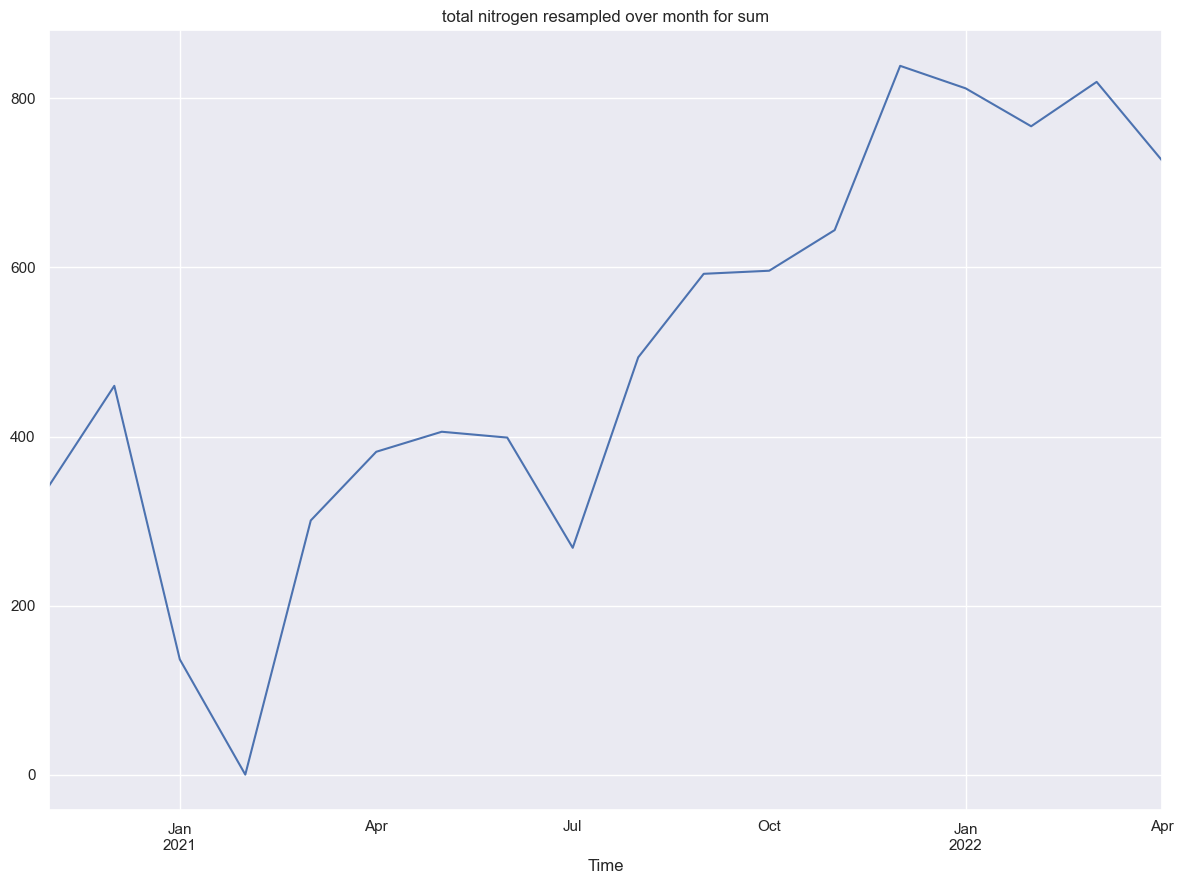

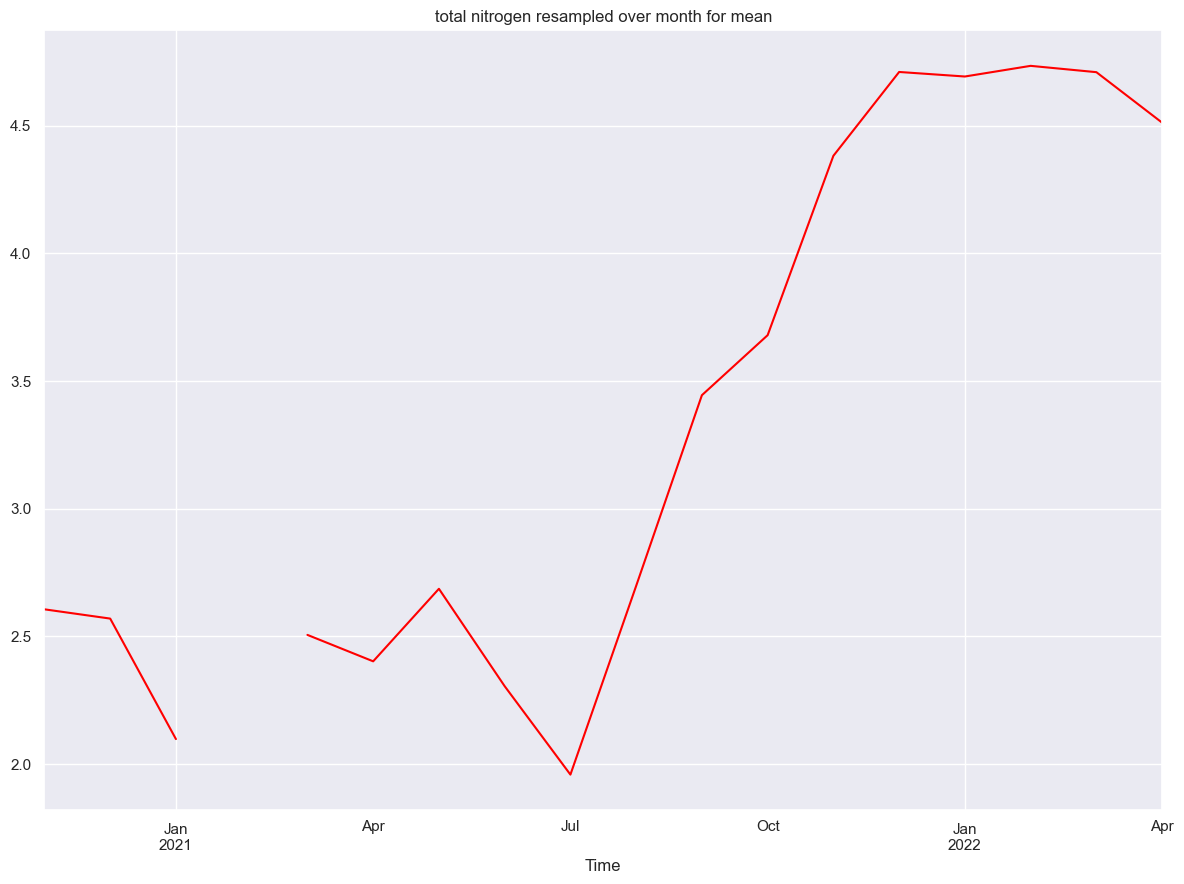

In [23]:
df['total nitrogen'].resample('m').sum().plot(title='total nitrogen resampled over month for sum') 
plt.tight_layout()
plt.show()   

df['total nitrogen'].resample('m').mean().plot(title='total nitrogen resampled over month for mean', color='red') 
plt.tight_layout()
plt.show()

total nitrogen resampled over years

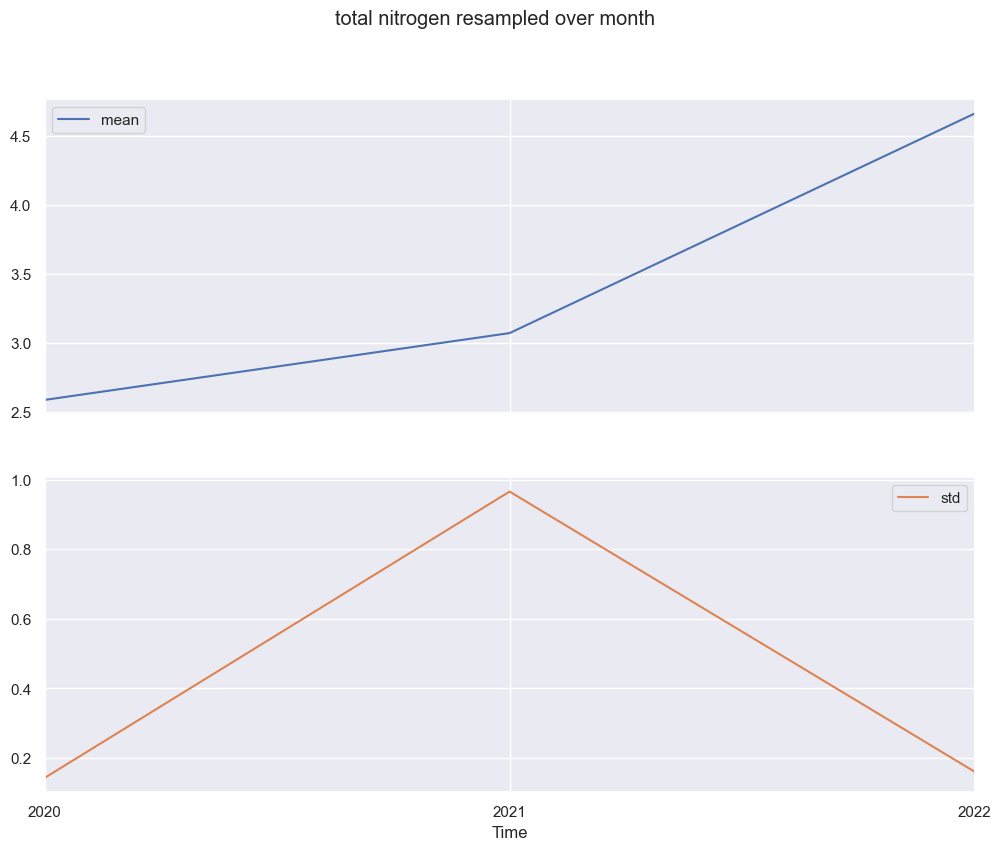

In [24]:
r = df['total nitrogen'].resample('y').agg(['mean', 'std'])
r.plot(subplots = True, title='total nitrogen resampled over year')
plt.show()

Averaged total nitrogen over year

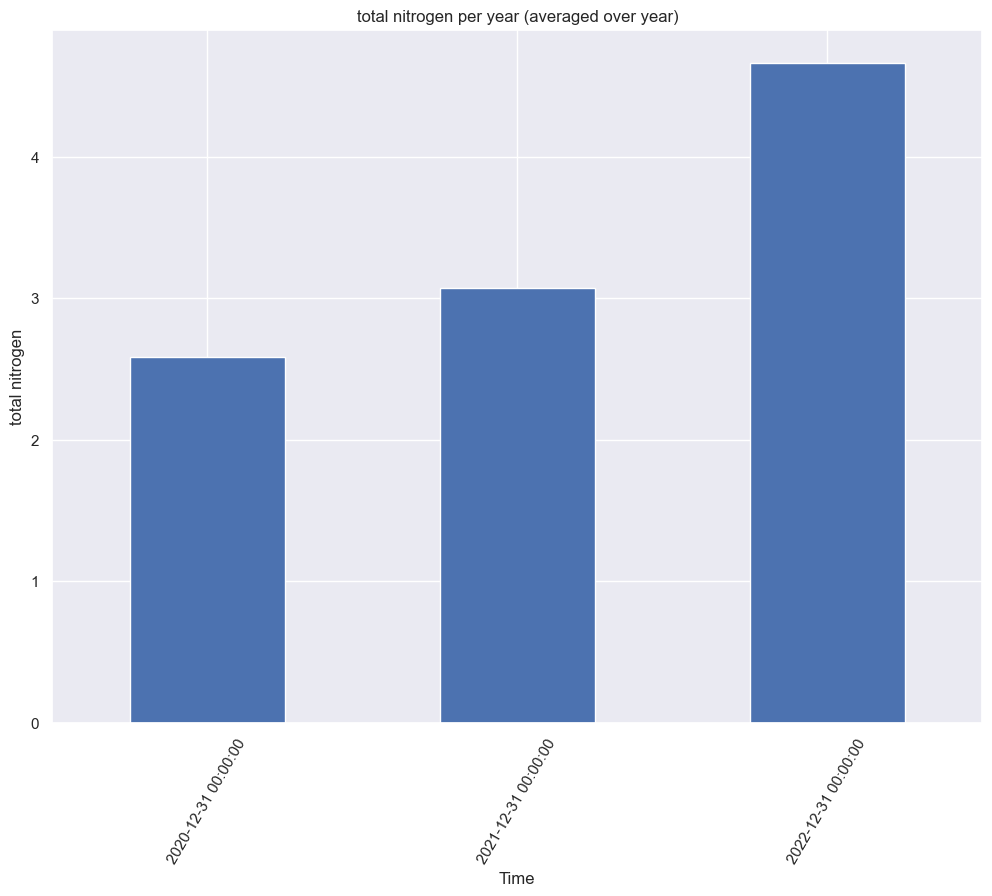

In [25]:
df['total nitrogen'].resample('y').mean().plot(kind='bar')
# plt.rcParams["figure.figsize"] = (20,10)
plt.xticks(rotation=60)
plt.ylabel('total nitrogen')
plt.title('total nitrogen per year (averaged over year)')
plt.show()

##### Series to supervised

In [26]:
df.head()

,Temperature,Potassium permanganate index,pH,Season,total nitrogen
Time,,,,,
2020-11-08 08:00:00,17.1,2.31,8.56,0,2.54
2020-11-08 12:00:00,18.2,2.32,8.58,0,2.80
2020-11-08 16:00:00,18.1,2.33,8.59,0,2.65
2020-11-08 20:00:00,17.5,2.23,8.58,0,2.59
2020-11-09 00:00:00,17.0,2.28,8.58,0,2.58


The data should be transformed into a supervised form before being fed to the model

In [105]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	dff = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(dff.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(dff.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = pd.concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg


In [29]:
df.head()

,Temperature,Potassium permanganate index,pH,Season,total nitrogen
Time,,,,,
2020-11-08 08:00:00,17.1,2.31,8.56,0,2.54
2020-11-08 12:00:00,18.2,2.32,8.58,0,2.80
2020-11-08 16:00:00,18.1,2.33,8.59,0,2.65
2020-11-08 20:00:00,17.5,2.23,8.58,0,2.59
2020-11-09 00:00:00,17.0,2.28,8.58,0,2.58


We use the MinMaxScaler to normalize the data. It is done according to the following formula
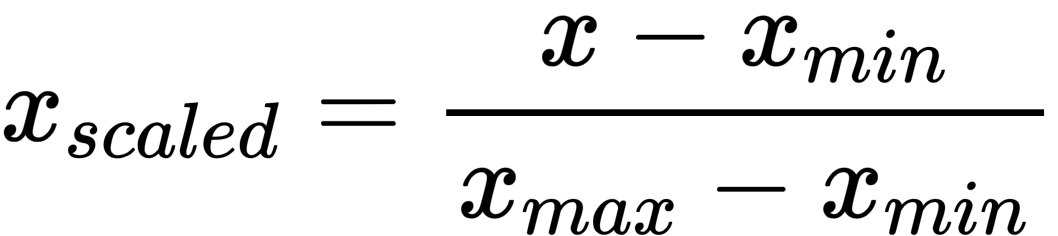

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1)) # initialize the scaler
scaled = scaler.fit_transform(df.values) # scaling the data
seq = series_to_supervised(scaled,1,1) # transforming the data into the appropriate form with a lookback of 1
seq.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
1,0.534202,0.522843,0.824543,0.0,0.452718,0.578956,0.525381,0.834456,0.0,0.509864
2,0.578956,0.525381,0.834456,0.0,0.509864,0.574887,0.527919,0.839412,0.0,0.476895
3,0.574887,0.527919,0.839412,0.0,0.476895,0.550476,0.502538,0.834456,0.0,0.463708
4,0.550476,0.502538,0.834456,0.0,0.463708,0.530133,0.515228,0.834456,0.0,0.461510
5,0.530133,0.515228,0.834456,0.0,0.461510,0.526065,0.512690,0.829500,0.0,0.441729


In [40]:
seq.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2595 entries, 1 to 2626
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   var1(t-1)  2595 non-null   float64
 1   var2(t-1)  2595 non-null   float64
 2   var3(t-1)  2595 non-null   float64
 3   var4(t-1)  2595 non-null   float64
 4   var5(t-1)  2595 non-null   float64
 5   var1(t)    2595 non-null   float64
 6   var2(t)    2595 non-null   float64
 7   var3(t)    2595 non-null   float64
 8   var4(t)    2595 non-null   float64
 9   var5(t)    2595 non-null   float64
dtypes: float64(10)
memory usage: 223.0 KB


**Splitting the data**

we take the following number of samples for each set:<br>
* Training : 1460 samples 
* Validation : 730 samples
* Test : 405 samples

In [8]:
values = seq.values

n_train_time = 365*4 # 365 days, and 4 years
n_val_time = 365*6
train = values[:n_train_time, :]
val = values[n_train_time:n_val_time, :]
test = values[n_val_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(1460, 1, 9) (1460,) (730, 1, 9) (730,) (405, 1, 9) (405,)


### **Training the models : lookback = 1**

##### **LSTM**

In [50]:
model = Sequential() # initialize the model
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]))) # the first layer is the LSTM layer, with 512 nodes, and the input shape (shape of the data)
model.add(Dropout(0.2)) # a dropout layer to help reduce overfitting
model.add(Dense(8,activation='relu')) # a fully connected layer
model.add(Dense(1)) # the regression layer

# we compile the model using the RMSE function and the 'Adam' optimizer (we do the same for all of the models to keep the comparison fair)
model.compile(loss=root_mean_squared_error, optimizer='adam') 

# we use callbacks for this model:
## ReduceLROnPlateau : decreases the value of the learning rate every 5 epochs if the loss didn't improve (in the last 5 epochs)
## ModelCheckpoint : saves the best model
callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-lstm-first.h5', verbose=1, save_best_only=True)
]

# fit model, 
# ## training the model using the training data
# ## for 200 epochs
# ## with a batchsize of 32
# ## we use the validation data to validate the model
# ## 'shuffle' is set to False, to preserve the sequential aspect 
# ## we also use the previously defined callbacks
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.60915, saving model to model-aitmelloul_pr_salwa.h5
46/46 - 4s - loss: 0.2419 - val_loss: 0.6092 - lr: 0.0010 - 4s/epoch - 84ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.60915 to 0.45237, saving model to model-aitmelloul_pr_salwa.h5
46/46 - 0s - loss: 0.1299 - val_loss: 0.4524 - lr: 0.0010 - 356ms/epoch - 8ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.45237
46/46 - 0s - loss: 0.1100 - val_loss: 0.4623 - lr: 0.0010 - 311ms/epoch - 7ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.45237 to 0.29133, saving model to model-aitmelloul_pr_salwa.h5
46/46 - 0s - loss: 0.0764 - val_loss: 0.2913 - lr: 0.0010 - 374ms/epoch - 8ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.29133
46/46 - 0s - loss: 0.0964 - val_loss: 0.3530 - lr: 0.0010 - 329ms/epoch - 7ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.29133
46/46 - 0s - loss: 0.0745 - val_loss: 0.3181 - lr: 0.0010 - 359ms/epoch - 8ms/ste

Drawing the training progress

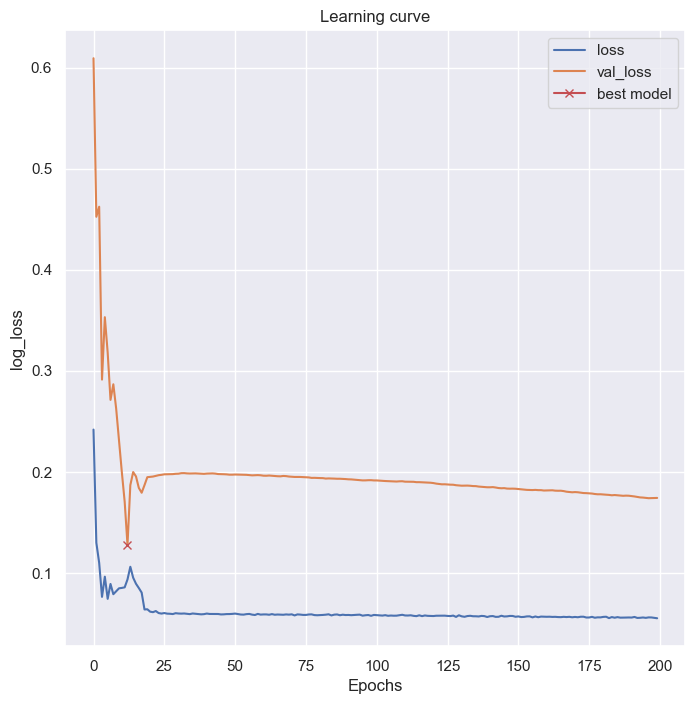

In [51]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

**Testing the model**

We use the data to test the model<br>
The predicted values should be inverted using the function "scaler.inverse_transform"<br>
Three metrics are computed:
* RMSE
* R2 score
* MAE

In [52]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


46/46 [==============================] - 1s 7ms/step
Train RMSE: 0.554
Train MAE : 0.167
Train R2  : 0.9521
23/23 [==============================] - 0s 9ms/step
Validation RMSE: 1.483
Validation MAE : 0.654
Validation R2  : 0.8417
13/13 [==============================] - 0s 5ms/step
Test RMSE: 1.910
Test MAE : 0.898
Test R2  : 0.8029


We take the second column of the inverted real values and the predicted values (this column is the total nitrogen)

In [53]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]

We plot the actual and predicted values of total nitrogen

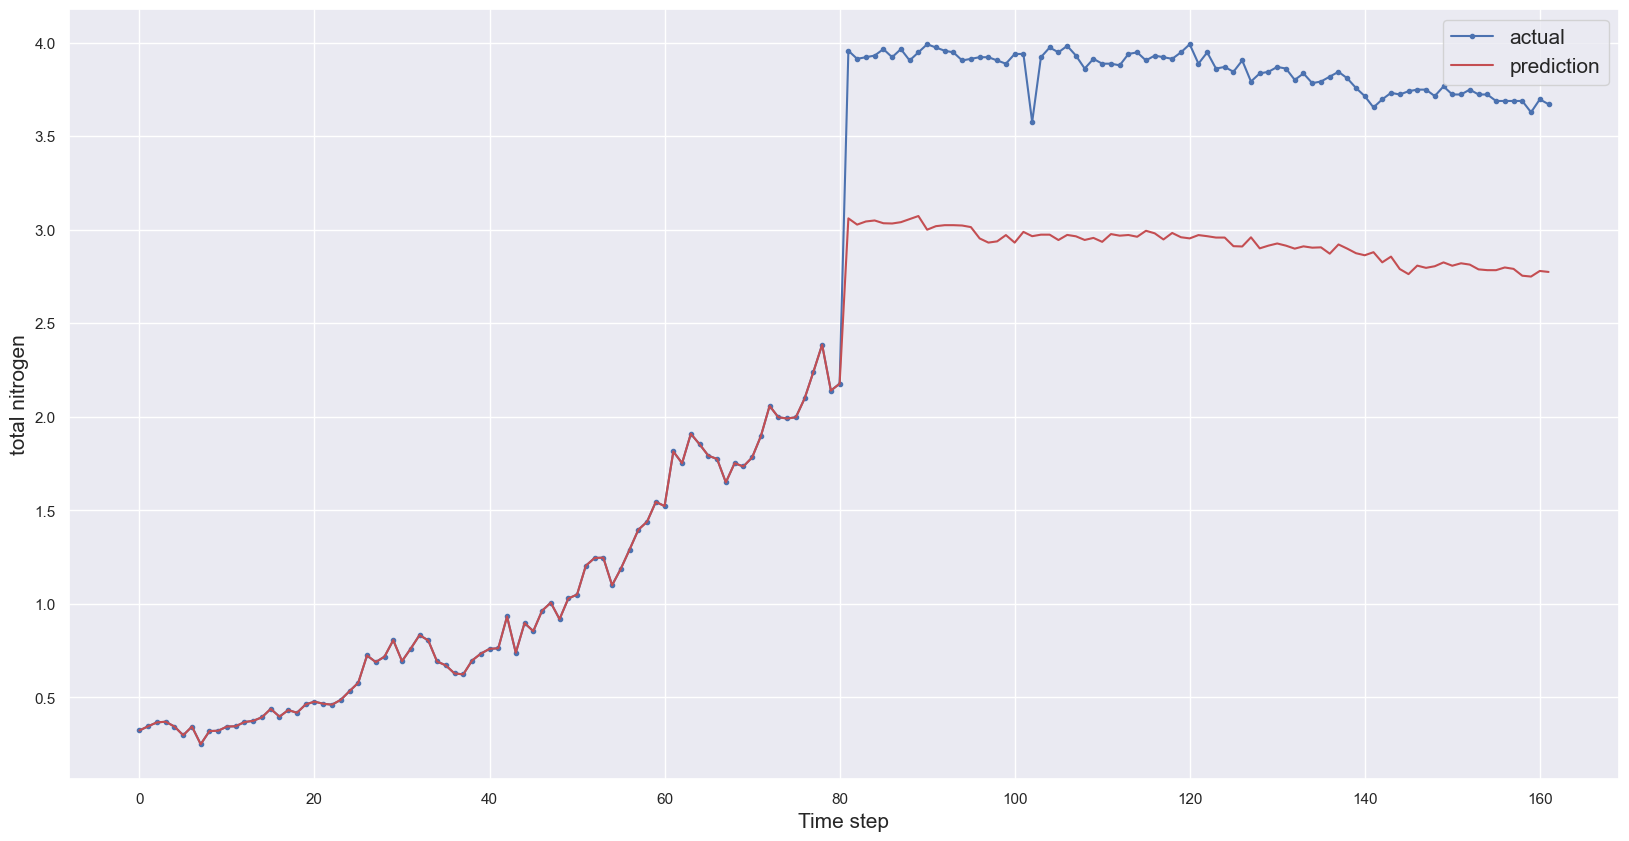

In [55]:
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **Bidirectional LSTM**

In the same manner, we defined Bidirectional LSTM model

In [70]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-bid-lstm-first.h5', verbose=1, save_best_only=True)
]

# note that all of the parameters are the same except the epochs and bachsize
history = model.fit(train_X, train_y, epochs=500, batch_size=64, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)

Epoch 1/500

Epoch 1: val_loss did not improve from 0.12785
23/23 - 11s - loss: 0.2570 - val_loss: 0.4578 - lr: 0.0010 - 11s/epoch - 479ms/step
Epoch 2/500

Epoch 2: val_loss did not improve from 0.12785
23/23 - 0s - loss: 0.1390 - val_loss: 0.6254 - lr: 0.0010 - 401ms/epoch - 17ms/step
Epoch 3/500

Epoch 3: val_loss did not improve from 0.12785
23/23 - 0s - loss: 0.1535 - val_loss: 0.3843 - lr: 0.0010 - 377ms/epoch - 16ms/step
Epoch 4/500

Epoch 4: val_loss did not improve from 0.12785
23/23 - 0s - loss: 0.1058 - val_loss: 0.4822 - lr: 0.0010 - 359ms/epoch - 16ms/step
Epoch 5/500

Epoch 5: val_loss did not improve from 0.12785
23/23 - 0s - loss: 0.1007 - val_loss: 0.3532 - lr: 0.0010 - 327ms/epoch - 14ms/step
Epoch 6/500

Epoch 6: val_loss did not improve from 0.12785
23/23 - 0s - loss: 0.0756 - val_loss: 0.3053 - lr: 0.0010 - 326ms/epoch - 14ms/step
Epoch 7/500

Epoch 7: val_loss did not improve from 0.12785
23/23 - 0s - loss: 0.0810 - val_loss: 0.2984 - lr: 0.0010 - 329ms/epoch - 14

Plot the training progress

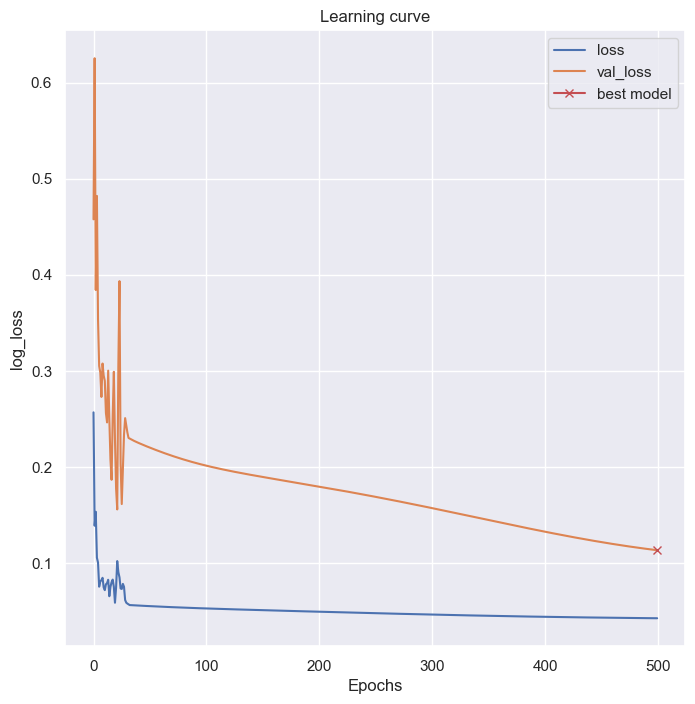

In [71]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Testing the model

In [72]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


46/46 [==============================] - 2s 6ms/step
Train RMSE: 0.500
Train MAE : 0.115
Train R2  : 0.9622
23/23 [==============================] - 0s 6ms/step
Validation RMSE: 0.947
Validation MAE : 0.421
Validation R2  : 0.9339
13/13 [==============================] - 0s 6ms/step
Test RMSE: 0.949
Test MAE : 0.438
Test R2  : 0.9515


Plot the actual and predicted values

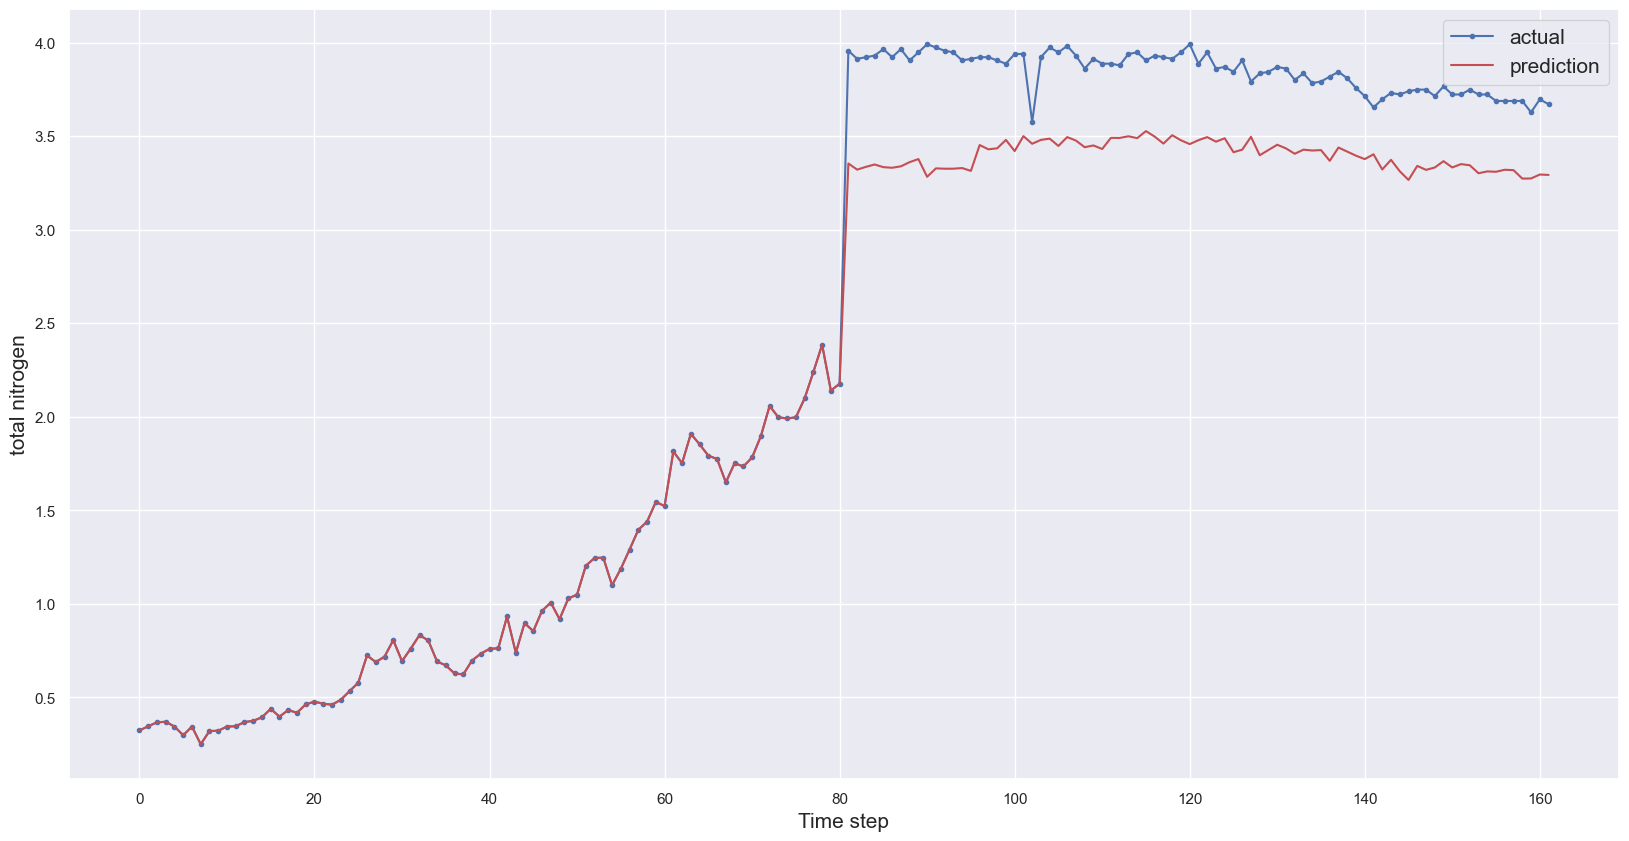

In [74]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **Bidrectional GRU**

model is defined in the same manner previously described

In [12]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-bid-gru-first.h5', verbose=1, save_best_only=True)
]

history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False, callbacks=callbacks)

Epoch 1/200
46/46 - 22s - loss: 0.1111 - val_loss: 0.4205 - 22s/epoch - 481ms/step
Epoch 2/200
46/46 - 1s - loss: 0.1000 - val_loss: 0.3965 - 822ms/epoch - 18ms/step
Epoch 3/200
46/46 - 1s - loss: 0.0946 - val_loss: 0.3722 - 855ms/epoch - 19ms/step
Epoch 4/200
46/46 - 1s - loss: 0.0973 - val_loss: 0.3842 - 799ms/epoch - 17ms/step
Epoch 5/200
46/46 - 1s - loss: 0.0955 - val_loss: 0.3751 - 883ms/epoch - 19ms/step
Epoch 6/200
46/46 - 1s - loss: 0.0921 - val_loss: 0.3885 - 967ms/epoch - 21ms/step
Epoch 7/200
46/46 - 1s - loss: 0.0905 - val_loss: 0.3775 - 875ms/epoch - 19ms/step
Epoch 8/200
46/46 - 1s - loss: 0.0873 - val_loss: 0.3763 - 807ms/epoch - 18ms/step
Epoch 9/200
46/46 - 1s - loss: 0.0863 - val_loss: 0.3665 - 859ms/epoch - 19ms/step
Epoch 10/200
46/46 - 1s - loss: 0.0827 - val_loss: 0.3682 - 875ms/epoch - 19ms/step
Epoch 11/200
46/46 - 1s - loss: 0.0800 - val_loss: 0.3496 - 838ms/epoch - 18ms/step
Epoch 12/200
46/46 - 1s - loss: 0.0782 - val_loss: 0.3278 - 855ms/epoch - 19ms/step
E

plotting the training progress

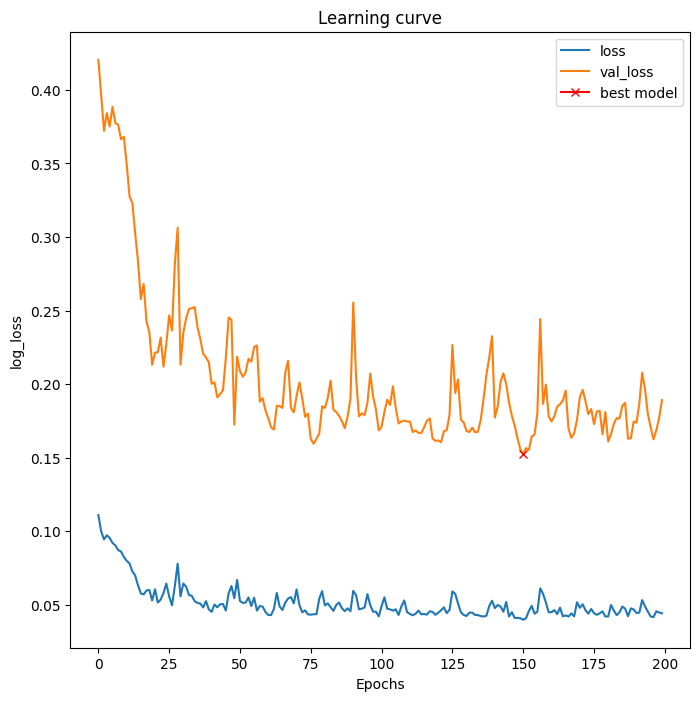

In [13]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Testing the model

In [14]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


46/46 [==============================] - 2s 7ms/step
Train RMSE: 0.582
Train MAE : 0.176
Train R2  : 0.9467
23/23 [==============================] - 0s 6ms/step
Validation RMSE: 1.649
Validation MAE : 0.709
Validation R2  : 0.8052
13/13 [==============================] - 0s 7ms/step
Test RMSE: 1.973
Test MAE : 0.923
Test R2  : 0.7902


Plotting the actual and predicted values

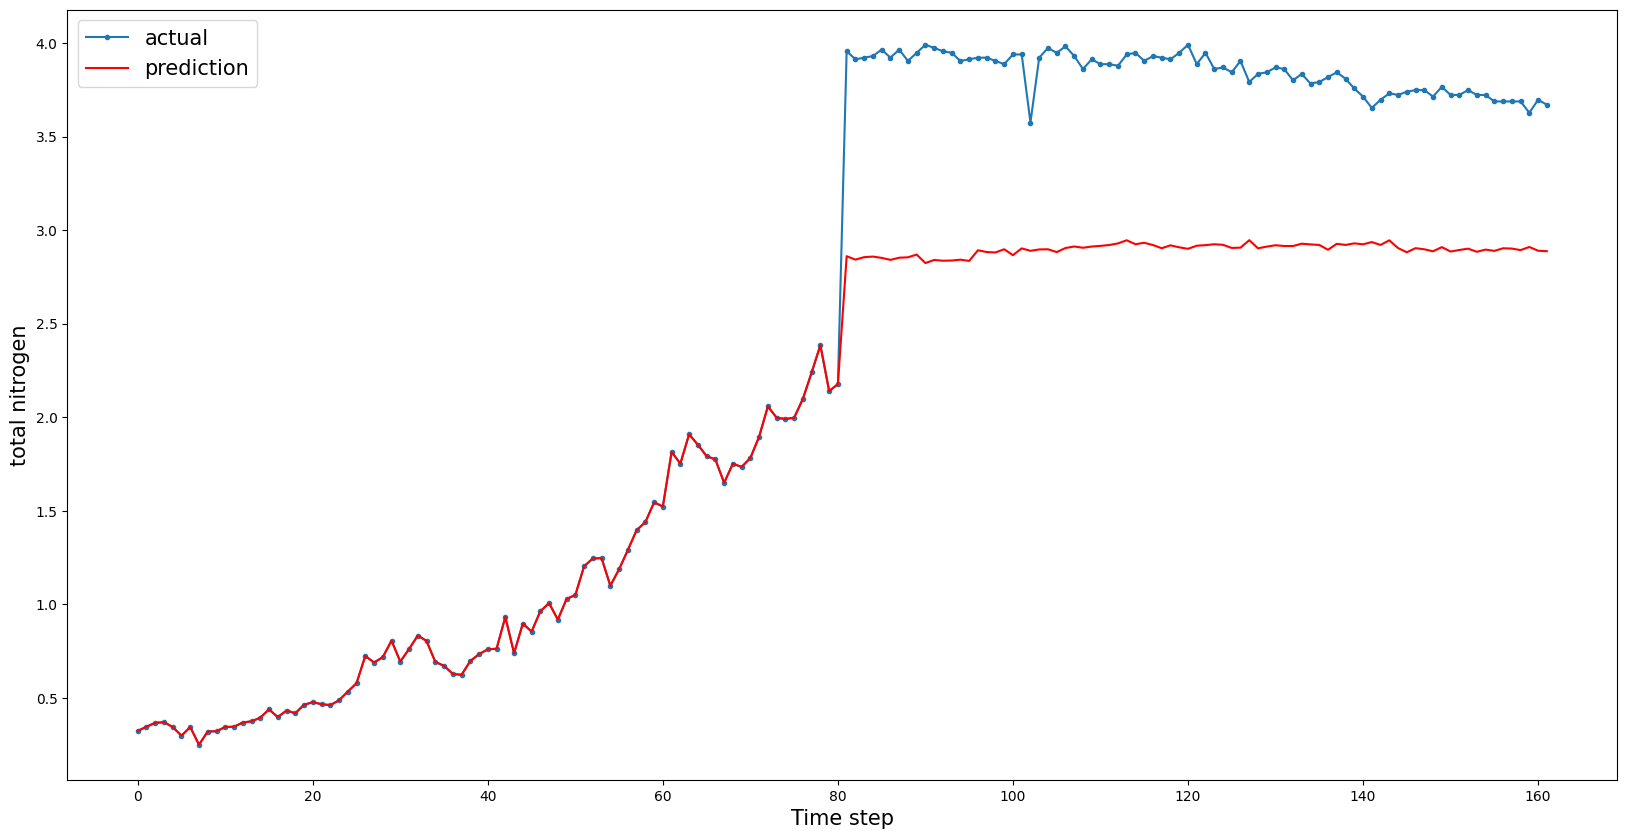

In [16]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **GRU**

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1)
])

model.compile(loss=root_mean_squared_error,optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model-gru-first.h5', verbose=1, save_best_only=True)
]

history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)

Epoch 1/200
46/46 - 7s - loss: 0.1072 - val_loss: 0.4340 - 7s/epoch - 152ms/step
Epoch 2/200
46/46 - 1s - loss: 0.1035 - val_loss: 0.4014 - 553ms/epoch - 12ms/step
Epoch 3/200
46/46 - 1s - loss: 0.0998 - val_loss: 0.4068 - 584ms/epoch - 13ms/step
Epoch 4/200
46/46 - 1s - loss: 0.0957 - val_loss: 0.3880 - 520ms/epoch - 11ms/step
Epoch 5/200
46/46 - 1s - loss: 0.0927 - val_loss: 0.3720 - 586ms/epoch - 13ms/step
Epoch 6/200
46/46 - 1s - loss: 0.0926 - val_loss: 0.3634 - 578ms/epoch - 13ms/step
Epoch 7/200
46/46 - 1s - loss: 0.0913 - val_loss: 0.3583 - 513ms/epoch - 11ms/step
Epoch 8/200
46/46 - 1s - loss: 0.0900 - val_loss: 0.3448 - 517ms/epoch - 11ms/step
Epoch 9/200
46/46 - 1s - loss: 0.0869 - val_loss: 0.3149 - 534ms/epoch - 12ms/step
Epoch 10/200
46/46 - 1s - loss: 0.0834 - val_loss: 0.2727 - 507ms/epoch - 11ms/step
Epoch 11/200
46/46 - 1s - loss: 0.0929 - val_loss: 0.3213 - 571ms/epoch - 12ms/step
Epoch 12/200
46/46 - 1s - loss: 0.0785 - val_loss: 0.2839 - 627ms/epoch - 14ms/step
Epo

Draw the training progress

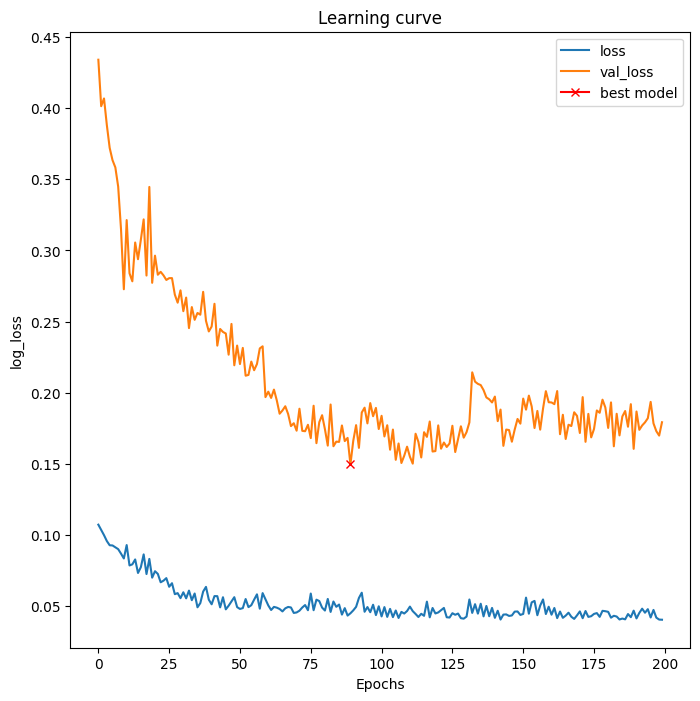

In [18]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Test the model

In [19]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


46/46 [==============================] - 2s 5ms/step
Train RMSE: 0.485
Train MAE : 0.113
Train R2  : 0.9647
23/23 [==============================] - 0s 5ms/step
Validation RMSE: 1.546
Validation MAE : 0.671
Validation R2  : 0.8281
13/13 [==============================] - 0s 5ms/step
Test RMSE: 1.756
Test MAE : 0.819
Test R2  : 0.8340


Plot the actual and predicted values

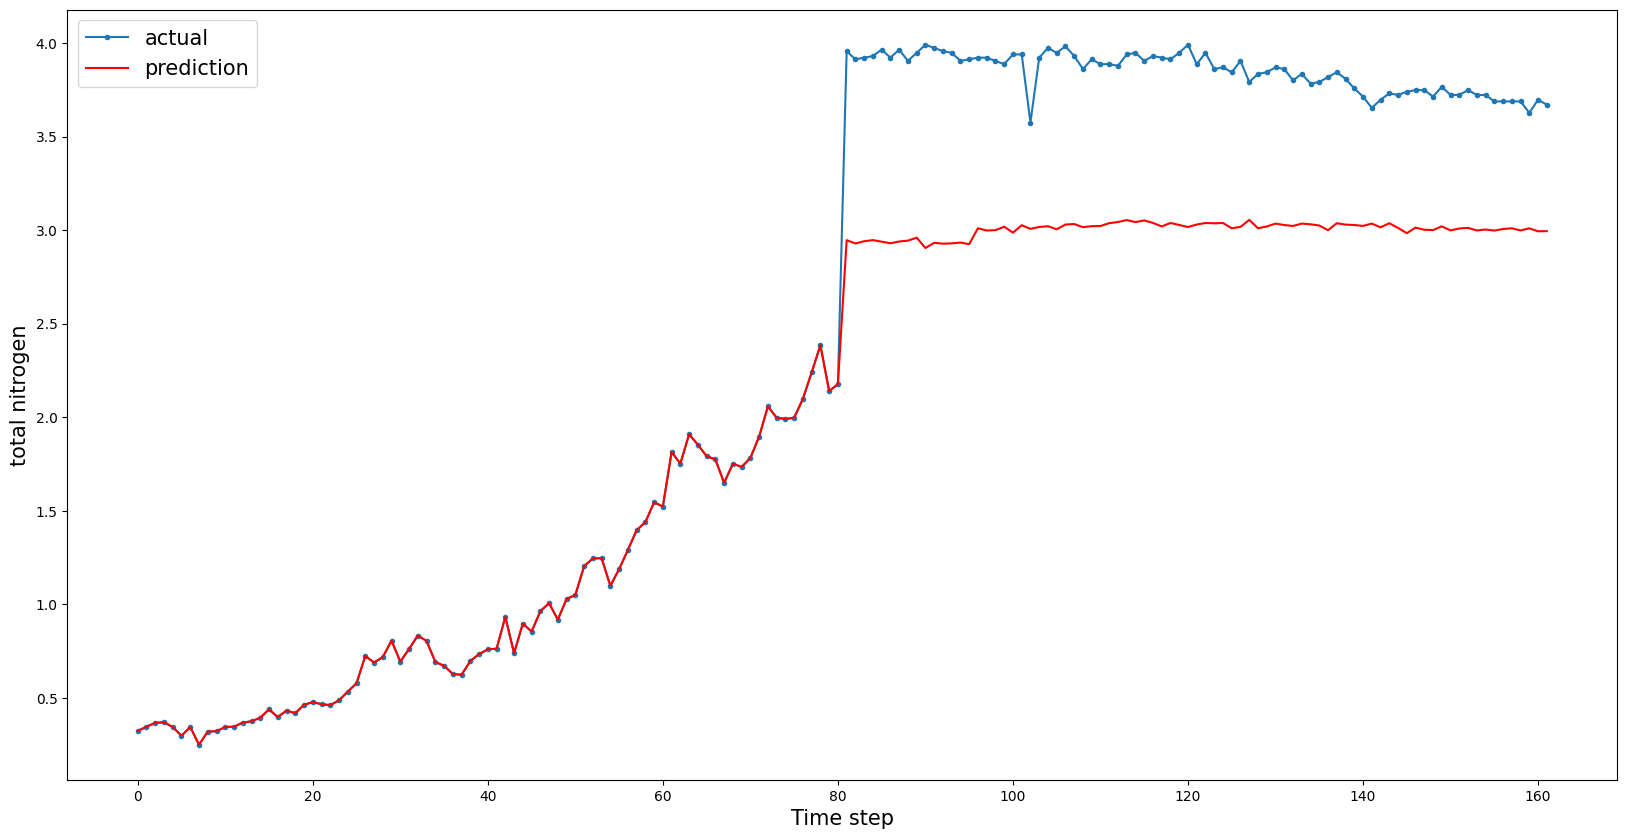

In [21]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### **Training the models : lookback = 10**

re-apply the scaler and the series to supervised function with a lookback of 10

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(df.values)
seq = series_to_supervised(scaled,10,1) # 10 is the lookback
seq.head()

,var1(t-10),var2(t-10),var3(t-10),var4(t-10),var5(t-10),var1(t-9),var2(t-9),var3(t-9),var4(t-9),var5(t-9),...,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var1(t),var2(t),var3(t),var4(t),var5(t)
10,0.534202,0.522843,0.824543,0.0,0.452718,0.578956,0.525381,0.834456,0.0,0.509864,...,0.619641,0.520305,0.750197,0.0,0.481291,0.526065,0.512690,0.829500,0.0,0.483489
11,0.578956,0.525381,0.834456,0.0,0.509864,0.574887,0.527919,0.839412,0.0,0.476895,...,0.526065,0.512690,0.829500,0.0,0.483489,0.517927,0.525381,0.829500,0.0,0.468104
12,0.574887,0.527919,0.839412,0.0,0.476895,0.550476,0.502538,0.834456,0.0,0.463708,...,0.517927,0.525381,0.829500,0.0,0.468104,0.517927,0.515228,0.829500,0.0,0.483489
13,0.550476,0.502538,0.834456,0.0,0.463708,0.530133,0.515228,0.834456,0.0,0.461510,...,0.517927,0.515228,0.829500,0.0,0.483489,0.542339,0.512690,0.829500,0.0,0.490083
14,0.530133,0.515228,0.834456,0.0,0.461510,0.526065,0.512690,0.829500,0.0,0.441729,...,0.542339,0.512690,0.829500,0.0,0.490083,0.554545,0.522843,0.839412,0.0,0.485687


we take the same percentage of the data for each set

In [107]:
values = seq.values

n_train_time = 365*4 # 365 days, and 4 years
n_val_time = 365*6 # the next 2 years
train = values[:n_train_time, :]
val = values[n_train_time:n_val_time, :]
test = values[n_val_time:, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(1460, 1, 54) (1460,) (730, 1, 54) (730,) (315, 1, 54) (315,)


##### **LSTM**

In [24]:
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(8,activation='relu'))
model.add(Dense(1))


model.compile(loss=root_mean_squared_error, optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_lstm_lb_10.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.31625, saving model to model_lstm.h5
46/46 - 6s - loss: 0.1080 - val_loss: 0.3162 - lr: 0.0010 - 6s/epoch - 121ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.31625 to 0.15943, saving model to model_lstm.h5
46/46 - 1s - loss: 0.1253 - val_loss: 0.1594 - lr: 0.0010 - 780ms/epoch - 17ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.15943
46/46 - 1s - loss: 0.1721 - val_loss: 0.4691 - lr: 0.0010 - 588ms/epoch - 13ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.15943
46/46 - 1s - loss: 0.1256 - val_loss: 0.3621 - lr: 0.0010 - 524ms/epoch - 11ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.15943
46/46 - 1s - loss: 0.0695 - val_loss: 0.4019 - lr: 0.0010 - 537ms/epoch - 12ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.15943
46/46 - 1s - loss: 0.0817 - val_loss: 0.3214 - lr: 0.0010 - 504ms/epoch - 11ms/step
Epoch 7/200

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0001

Training progress

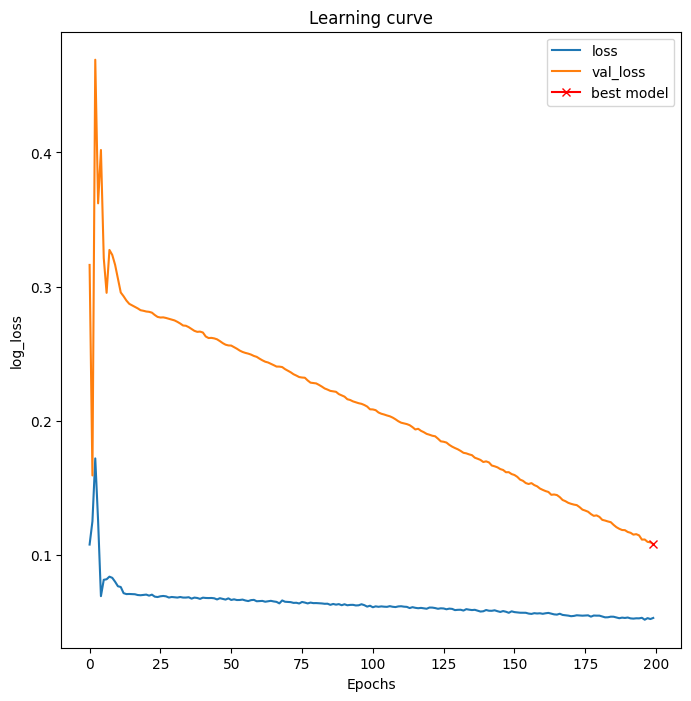

In [25]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Testing the model

In [33]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


46/46 [==============================] - 1s 8ms/step
Train RMSE: 0.511
Train MAE : 0.152
Train R2  : 0.9583
23/23 [==============================] - 0s 8ms/step
Validation RMSE: 0.880
Validation MAE : 0.404
Validation R2  : 0.9521
10/10 [==============================] - 0s 8ms/step
Test RMSE: 1.204
Test MAE : 0.564
Test R2  : 0.9111


Actual and predicted values

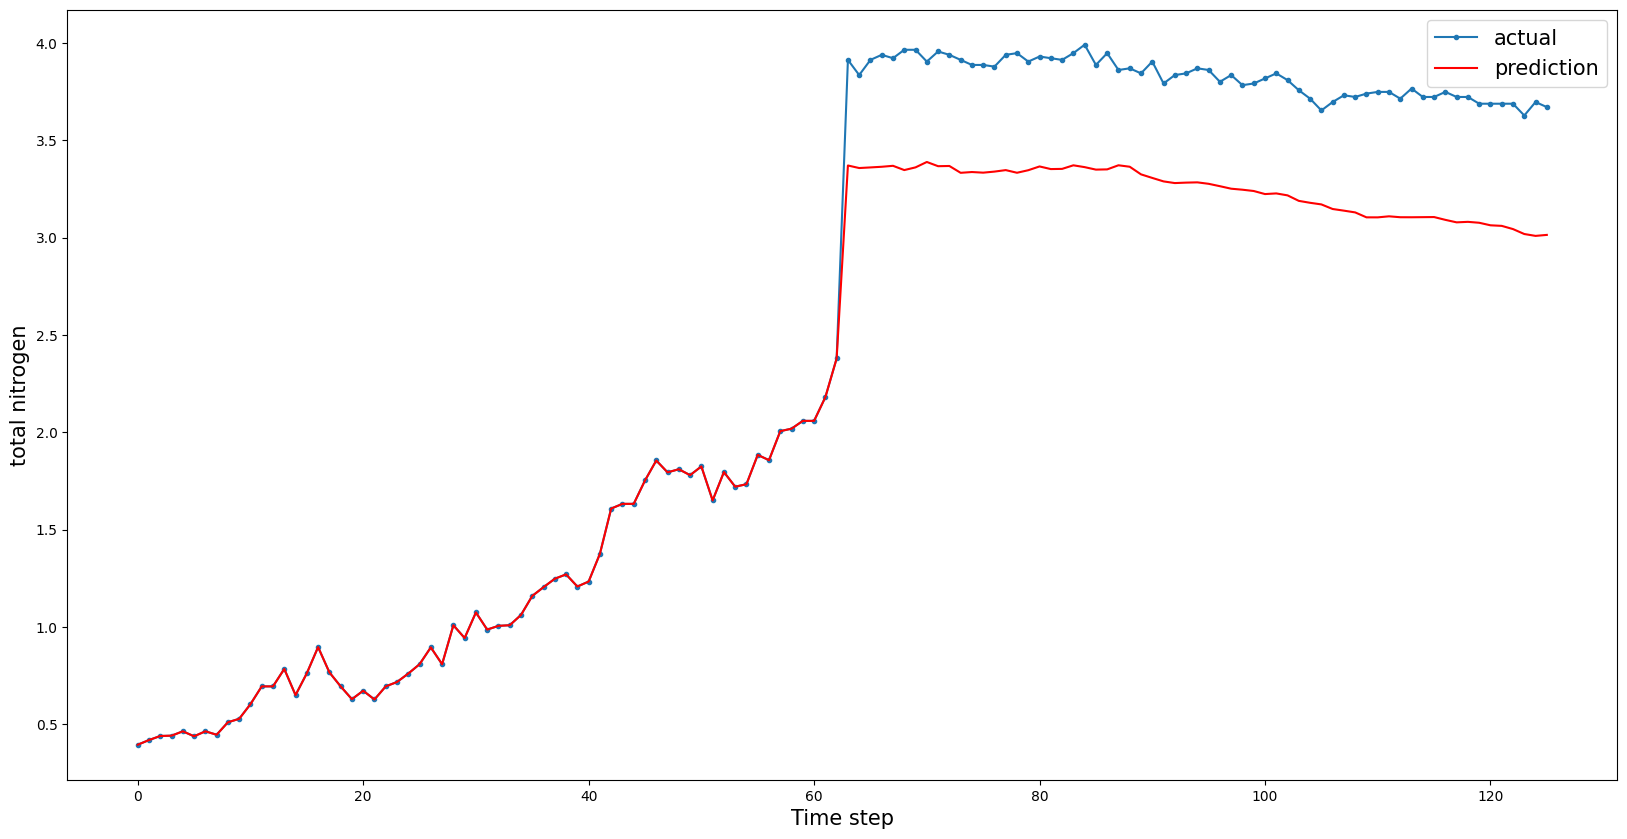

In [35]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **Bidirectional LSTM**

In [27]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_bid_lstm_lb_10.h5', verbose=1, save_best_only=True)
]

history = model.fit(train_X, train_y, epochs=200, batch_size=64, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)


Epoch 1/200
23/23 - 17s - loss: 0.2367 - val_loss: 0.4257 - 17s/epoch - 736ms/step
Epoch 2/200
23/23 - 1s - loss: 0.1198 - val_loss: 0.5077 - 538ms/epoch - 23ms/step
Epoch 3/200
23/23 - 1s - loss: 0.0978 - val_loss: 0.3544 - 532ms/epoch - 23ms/step
Epoch 4/200
23/23 - 1s - loss: 0.0754 - val_loss: 0.3009 - 589ms/epoch - 26ms/step
Epoch 5/200
23/23 - 1s - loss: 0.0861 - val_loss: 0.2480 - 508ms/epoch - 22ms/step
Epoch 6/200
23/23 - 1s - loss: 0.0996 - val_loss: 0.2593 - 523ms/epoch - 23ms/step
Epoch 7/200
23/23 - 1s - loss: 0.1188 - val_loss: 0.4387 - 568ms/epoch - 25ms/step
Epoch 8/200
23/23 - 1s - loss: 0.0680 - val_loss: 0.2548 - 544ms/epoch - 24ms/step
Epoch 9/200
23/23 - 1s - loss: 0.0844 - val_loss: 0.2578 - 579ms/epoch - 25ms/step
Epoch 10/200
23/23 - 1s - loss: 0.0826 - val_loss: 0.2242 - 636ms/epoch - 28ms/step
Epoch 11/200
23/23 - 1s - loss: 0.0962 - val_loss: 0.3176 - 635ms/epoch - 28ms/step
Epoch 12/200
23/23 - 1s - loss: 0.0551 - val_loss: 0.2603 - 559ms/epoch - 24ms/step
E

training progress

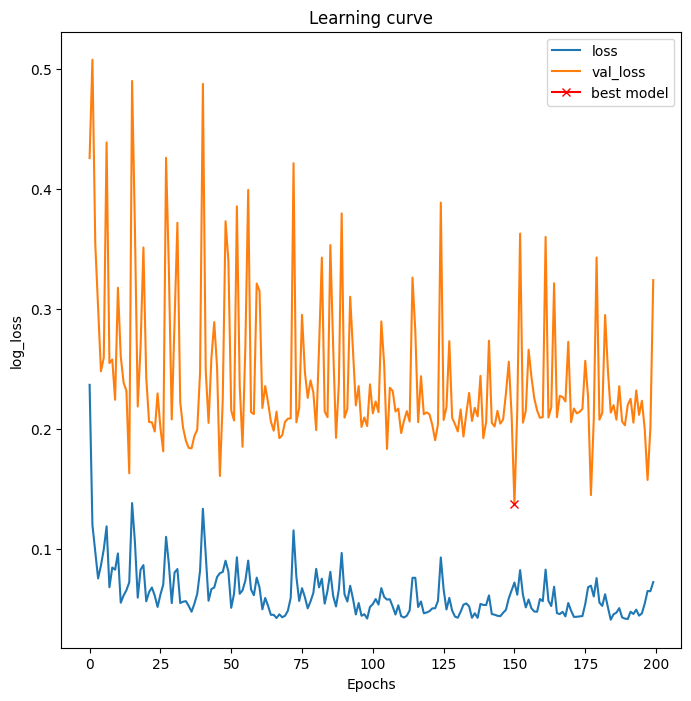

In [29]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

Testing the model

In [28]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


46/46 [==============================] - 3s 8ms/step
Train RMSE: 0.717
Train MAE : 0.289
Train R2  : 0.9143
23/23 [==============================] - 0s 8ms/step
Validation RMSE: 2.639
Validation MAE : 1.228
Validation R2  : 0.5824
10/10 [==============================] - 0s 10ms/step
Test RMSE: 2.658
Test MAE : 1.250
Test R2  : 0.5684


Actual and predicted values

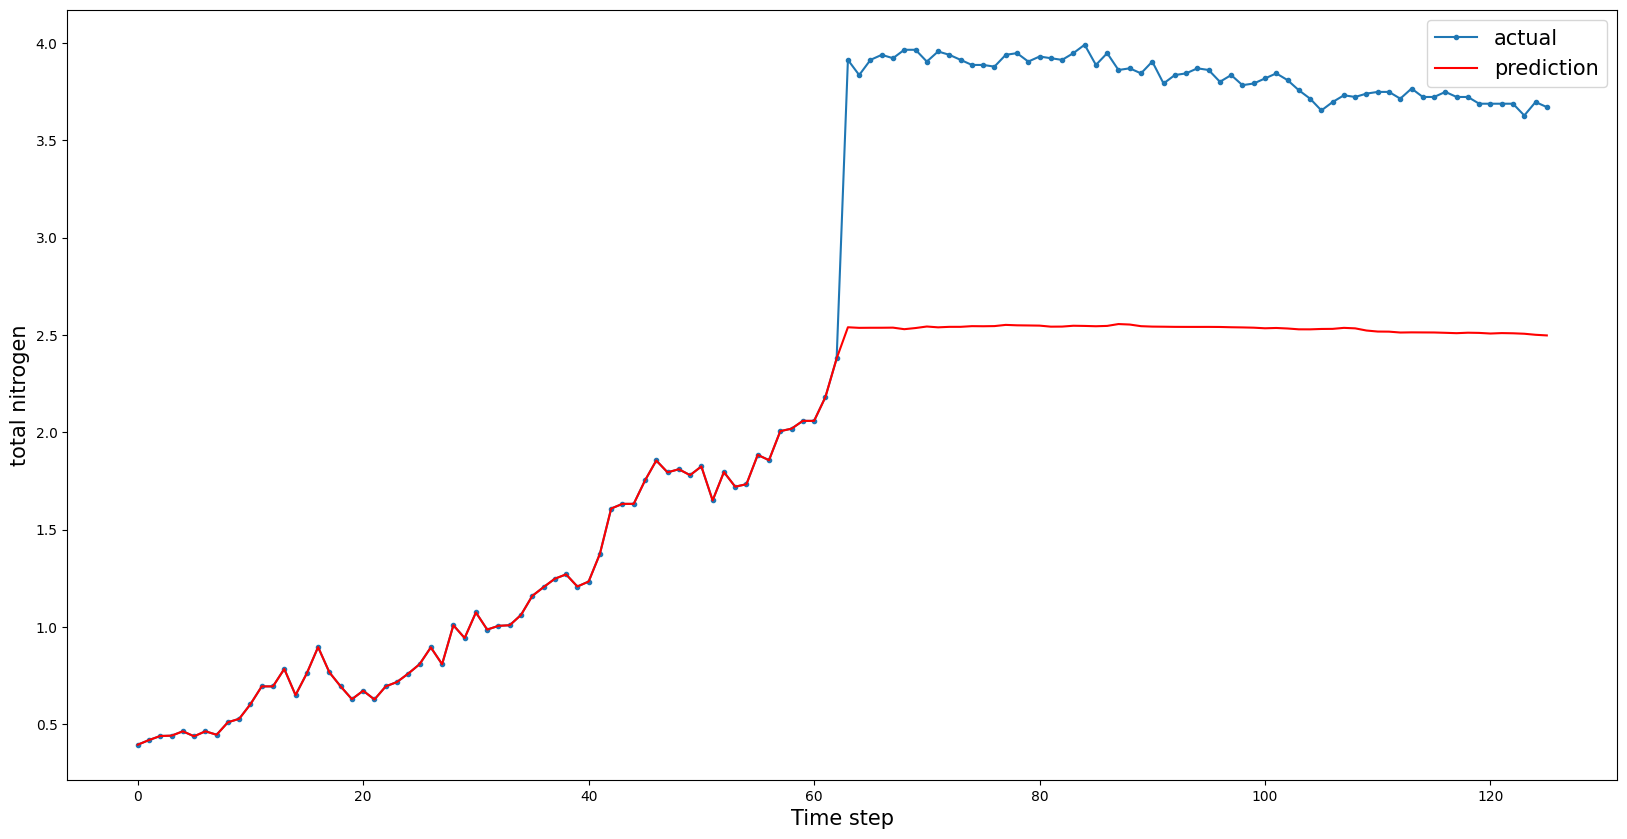

In [31]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

**Evaluation of the first 63 samples only (data before the spike)**

In [40]:
# len(inv_test_y[inv_test_y<2.5])
rmse = np.sqrt(mean_squared_error(inv_y_pred[:63], inv_test_y[inv_test_y<2.5]))
r2score = r2_score(inv_test_y[inv_test_y<2.5], inv_y_pred[:63])
mae = mean_absolute_error(inv_y_pred[:63], inv_test_y[inv_test_y<2.5])
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)

Test RMSE: 0.000
Test MAE : 0.000
Test R2  : 1.0000


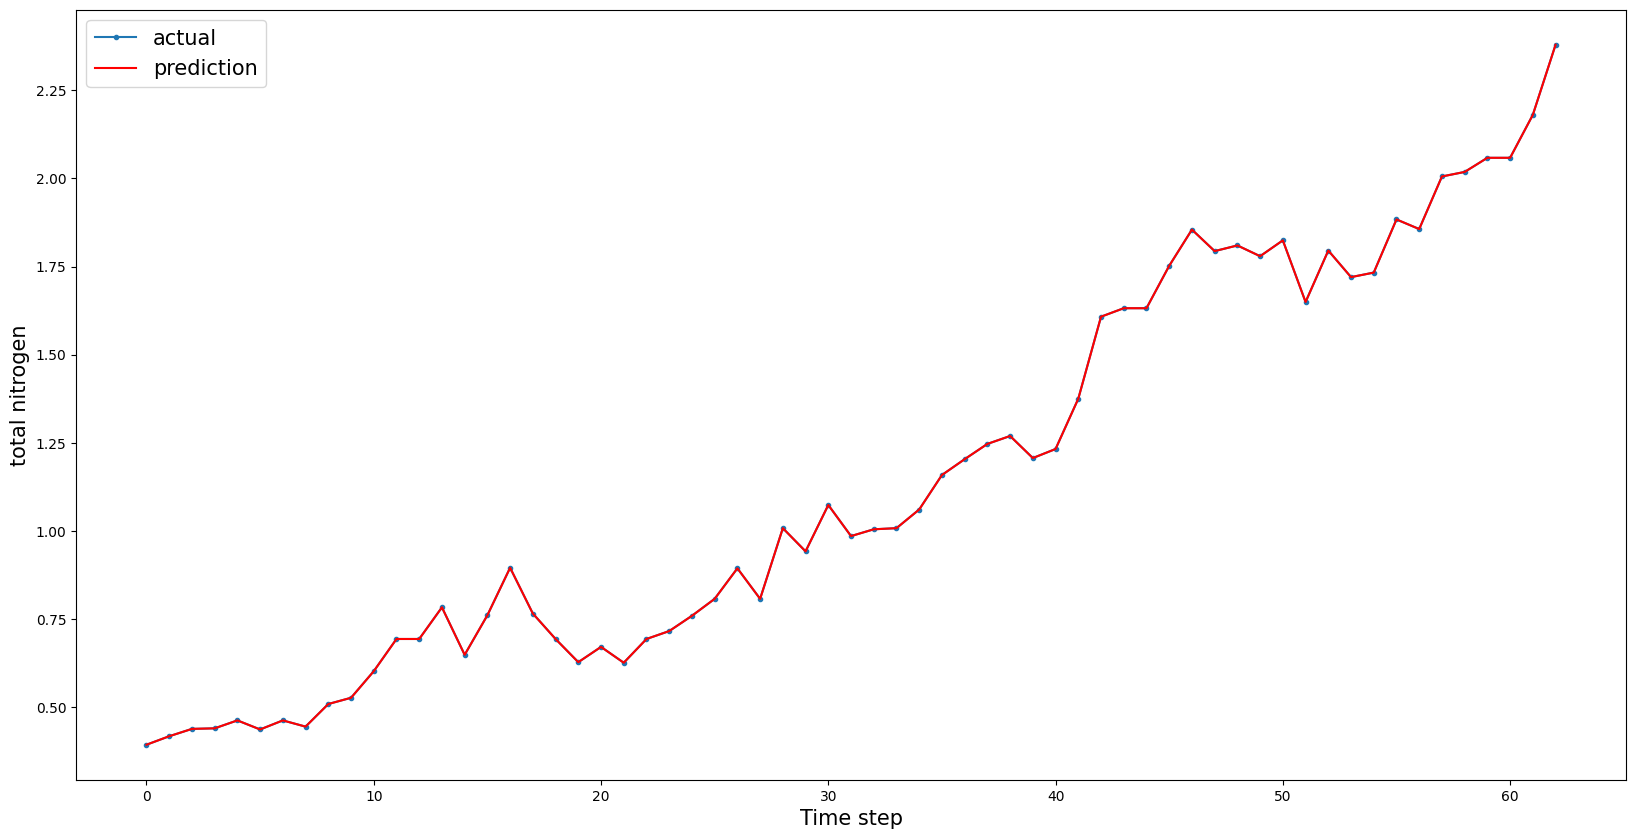

In [41]:
aa=[x for x in range(63)]
plt.plot(aa, inv_test_y[:63], marker='.', label="actual")
plt.plot(aa, inv_y_pred[:63], 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### **high number of test samples**

we use the same scaled values with the same lookback (10), but we take less training samples, and more test samples

In [108]:
values = seq.values

n_train_time = 365*3 # 365 days, and 40 years
n_val_time = 365*5
train = values[:n_train_time, :]
val = values[n_train_time:n_val_time, :]
test = values[n_val_time:, :]
##test = values[n_train_time:n_test_time, :]
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
val_X, val_y = val[:, :-1], val[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
val_X = val_X.reshape((val_X.shape[0], 1, val_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, val_X.shape, val_y.shape, test_X.shape, test_y.shape)

(1095, 1, 54) (1095,) (730, 1, 54) (730,) (680, 1, 54) (680,)


##### **LSTM**

In [109]:
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(8,activation='relu'))
model.add(Dense(1))


model.compile(loss=root_mean_squared_error, optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_lstm_less_training_samples_2.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.46219, saving model to model_lstm_less_training_samples_2.h5
35/35 - 5s - loss: 0.1690 - val_loss: 0.4622 - lr: 0.0010 - 5s/epoch - 142ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.46219 to 0.36922, saving model to model_lstm_less_training_samples_2.h5
35/35 - 0s - loss: 0.0988 - val_loss: 0.3692 - lr: 0.0010 - 487ms/epoch - 14ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.36922 to 0.27184, saving model to model_lstm_less_training_samples_2.h5
35/35 - 0s - loss: 0.0778 - val_loss: 0.2718 - lr: 0.0010 - 443ms/epoch - 13ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.27184 to 0.17292, saving model to model_lstm_less_training_samples_2.h5
35/35 - 0s - loss: 0.0615 - val_loss: 0.1729 - lr: 0.0010 - 387ms/epoch - 11ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.17292
35/35 - 0s - loss: 0.0746 - val_loss: 0.1946 - lr: 0.0010 - 332ms/epoch - 9ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from

training progress

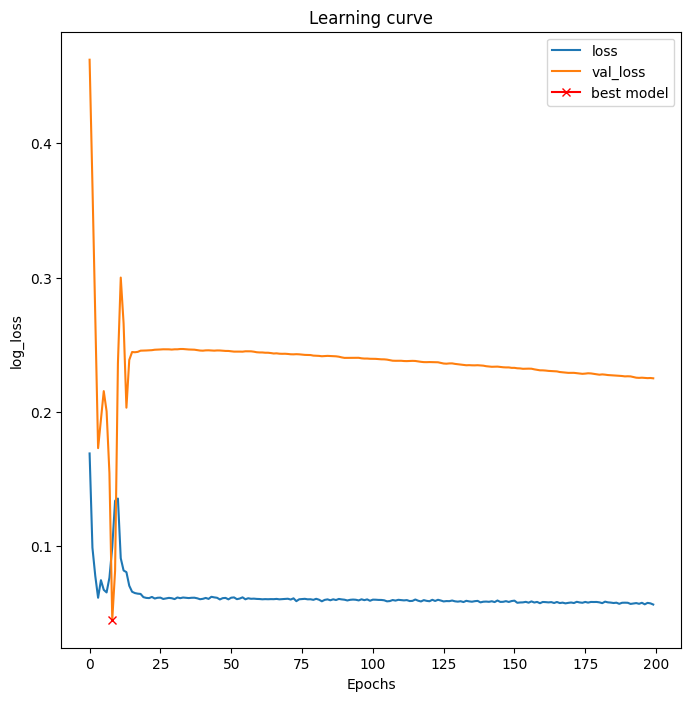

In [110]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

testing the model

In [111]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 1s 8ms/step
Train RMSE: 0.574
Train MAE : 0.164
Train R2  : 0.9327
23/23 [==============================] - 0s 11ms/step
Validation RMSE: 1.848
Validation MAE : 0.844
Validation R2  : 0.3447
22/22 [==============================] - 0s 8ms/step
Test RMSE: 2.109
Test MAE : 0.993
Test R2  : 0.7843


Actual and predicted values

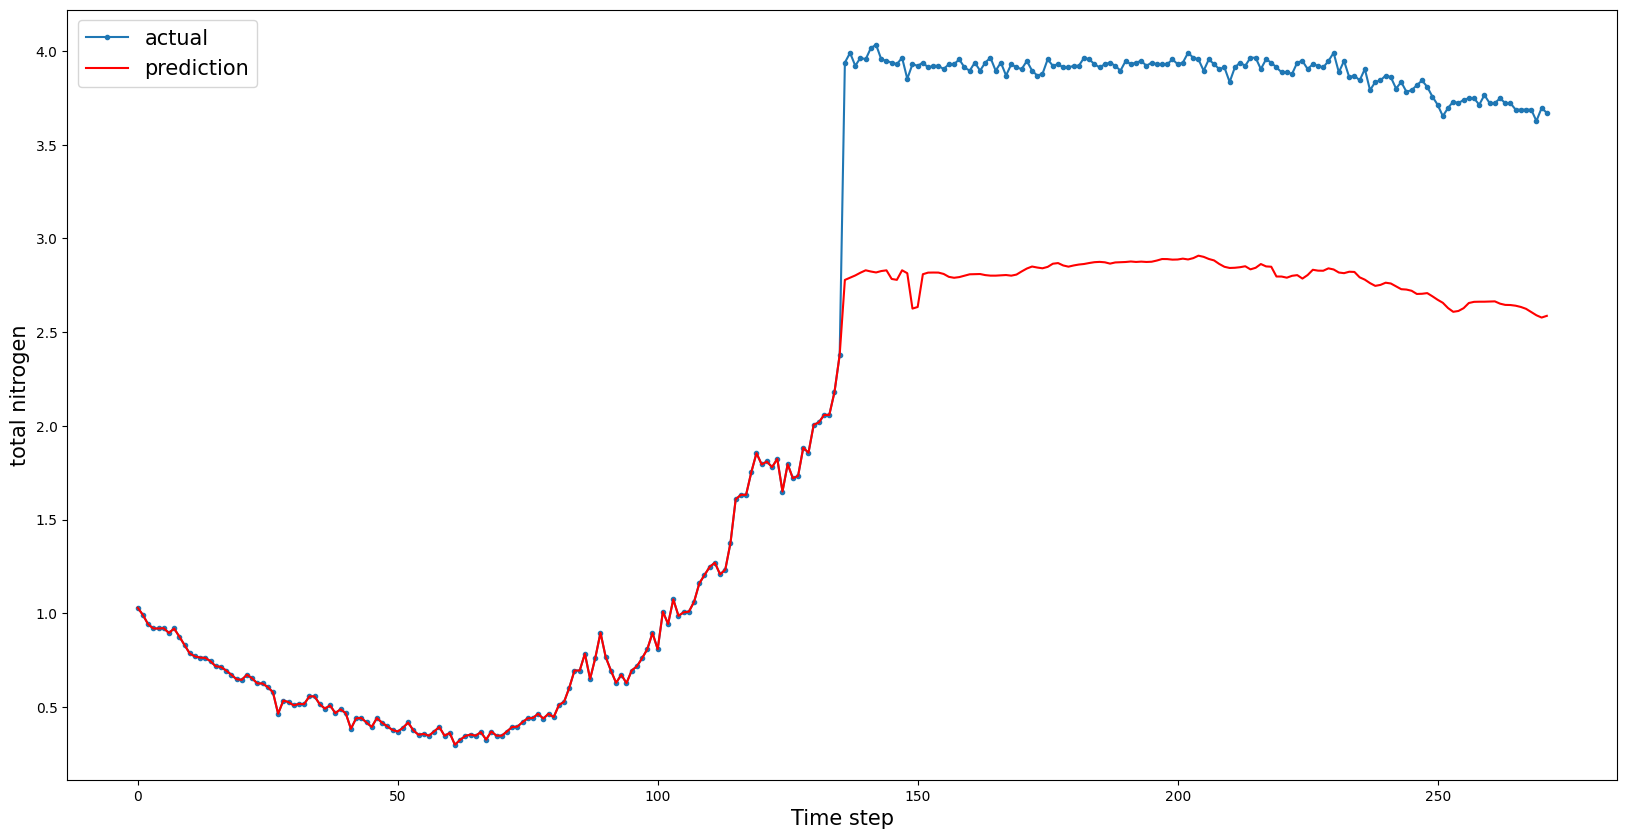

In [15]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

**loading and testing the saved model**

In [112]:
model = keras.models.load_model('model_lstm_less_training_samples_2.h5',custom_objects={'root_mean_squared_error':                   
root_mean_squared_error})
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 1s 8ms/step
Train RMSE: 1.408
Train MAE : 0.512
Train R2  : 0.5903
23/23 [==============================] - 0s 8ms/step
Validation RMSE: 0.475
Validation MAE : 0.155
Validation R2  : 0.9584
22/22 [==============================] - 0s 5ms/step
Test RMSE: 0.467
Test MAE : 0.186
Test R2  : 0.9881


actual and prediced values

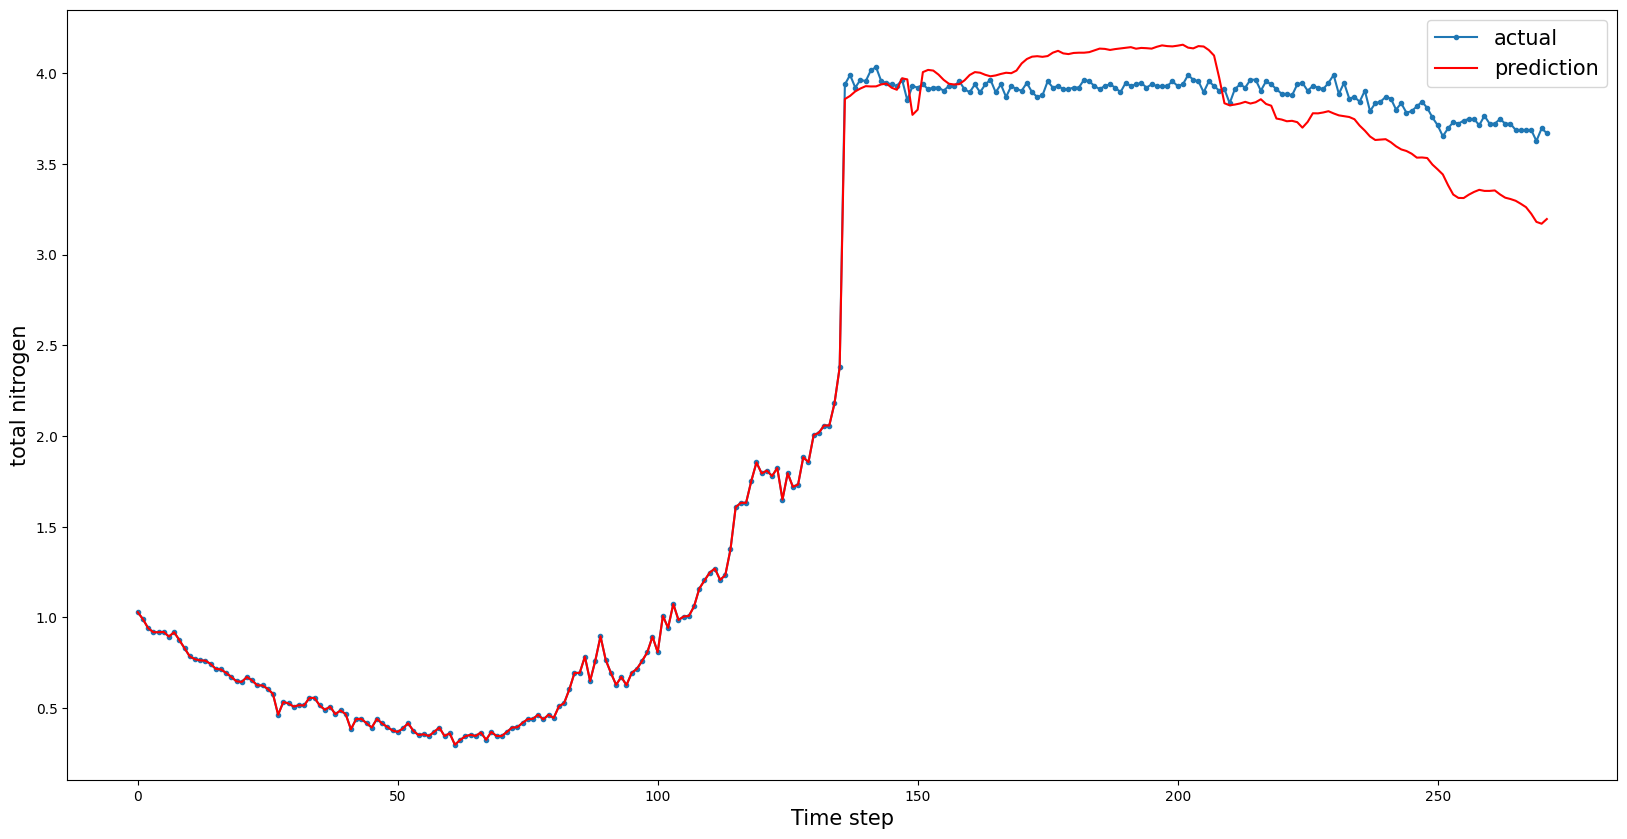

In [113]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **Bidirectional LSTM**

In [25]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_lstm_bid_less_training_samples.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.43254, saving model to model_lstm_bid_less_training_samples.h5
35/35 - 13s - loss: 0.1451 - val_loss: 0.4325 - lr: 0.0010 - 13s/epoch - 384ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.43254 to 0.30992, saving model to model_lstm_bid_less_training_samples.h5
35/35 - 1s - loss: 0.0865 - val_loss: 0.3099 - lr: 0.0010 - 691ms/epoch - 20ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.30992 to 0.16796, saving model to model_lstm_bid_less_training_samples.h5
35/35 - 1s - loss: 0.0649 - val_loss: 0.1680 - lr: 0.0010 - 645ms/epoch - 18ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.16796
35/35 - 1s - loss: 0.0729 - val_loss: 0.2210 - lr: 0.0010 - 530ms/epoch - 15ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.16796
35/35 - 1s - loss: 0.0617 - val_loss: 0.1896 - lr: 0.0010 - 598ms/epoch - 17ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.16796
35/35 - 1s - loss: 0.0644 - val_loss: 0.1

training progress

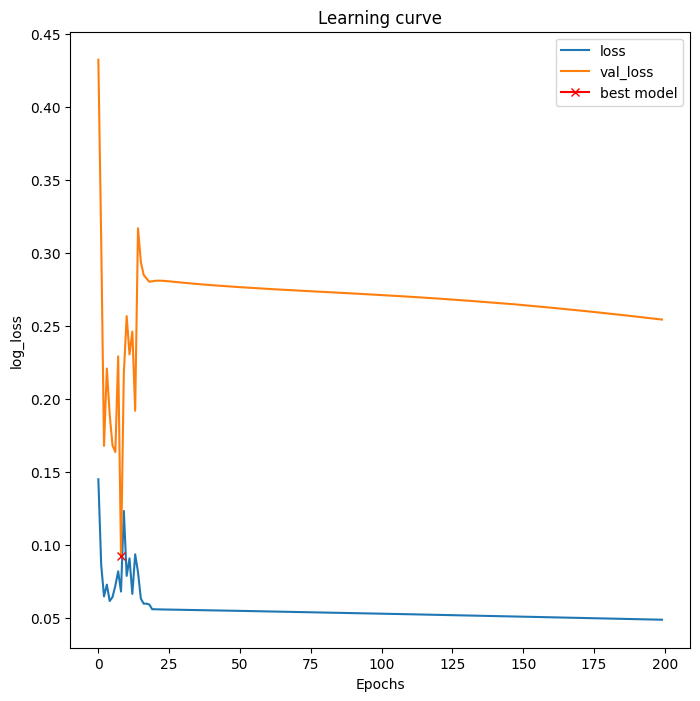

In [26]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

testing the model

In [27]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 3s 7ms/step
Train RMSE: 0.579
Train MAE : 0.141
Train R2  : 0.9305
23/23 [==============================] - 0s 7ms/step
Validation RMSE: 2.180
Validation MAE : 0.956
Validation R2  : 0.0888
22/22 [==============================] - 0s 7ms/step
Test RMSE: 3.010
Test MAE : 1.413
Test R2  : 0.5620


Drawing the actual and predicted values

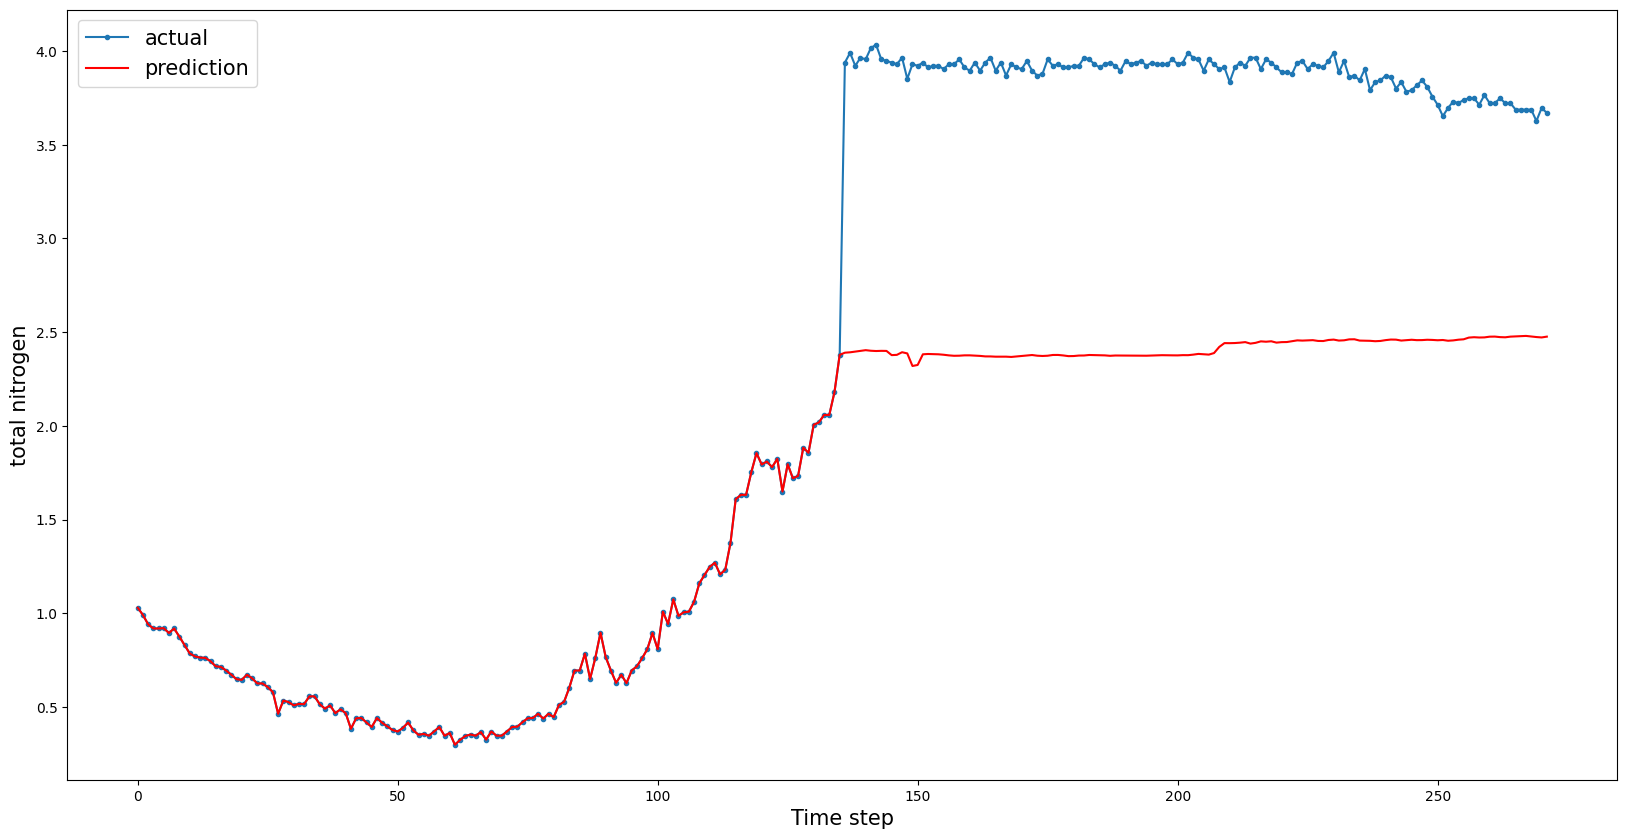

In [29]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

**loading and testing the saved model**

In [30]:
model = keras.models.load_model('model_lstm_bid_less_training_samples.h5',custom_objects={'root_mean_squared_error':                   
root_mean_squared_error})
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 2s 7ms/step
Train RMSE: 1.405
Train MAE : 0.555
Train R2  : 0.5908
23/23 [==============================] - 0s 8ms/step
Validation RMSE: 0.821
Validation MAE : 0.337
Validation R2  : 0.8700
22/22 [==============================] - 0s 7ms/step
Test RMSE: 0.737
Test MAE : 0.343
Test R2  : 0.9724


actual and predicted values

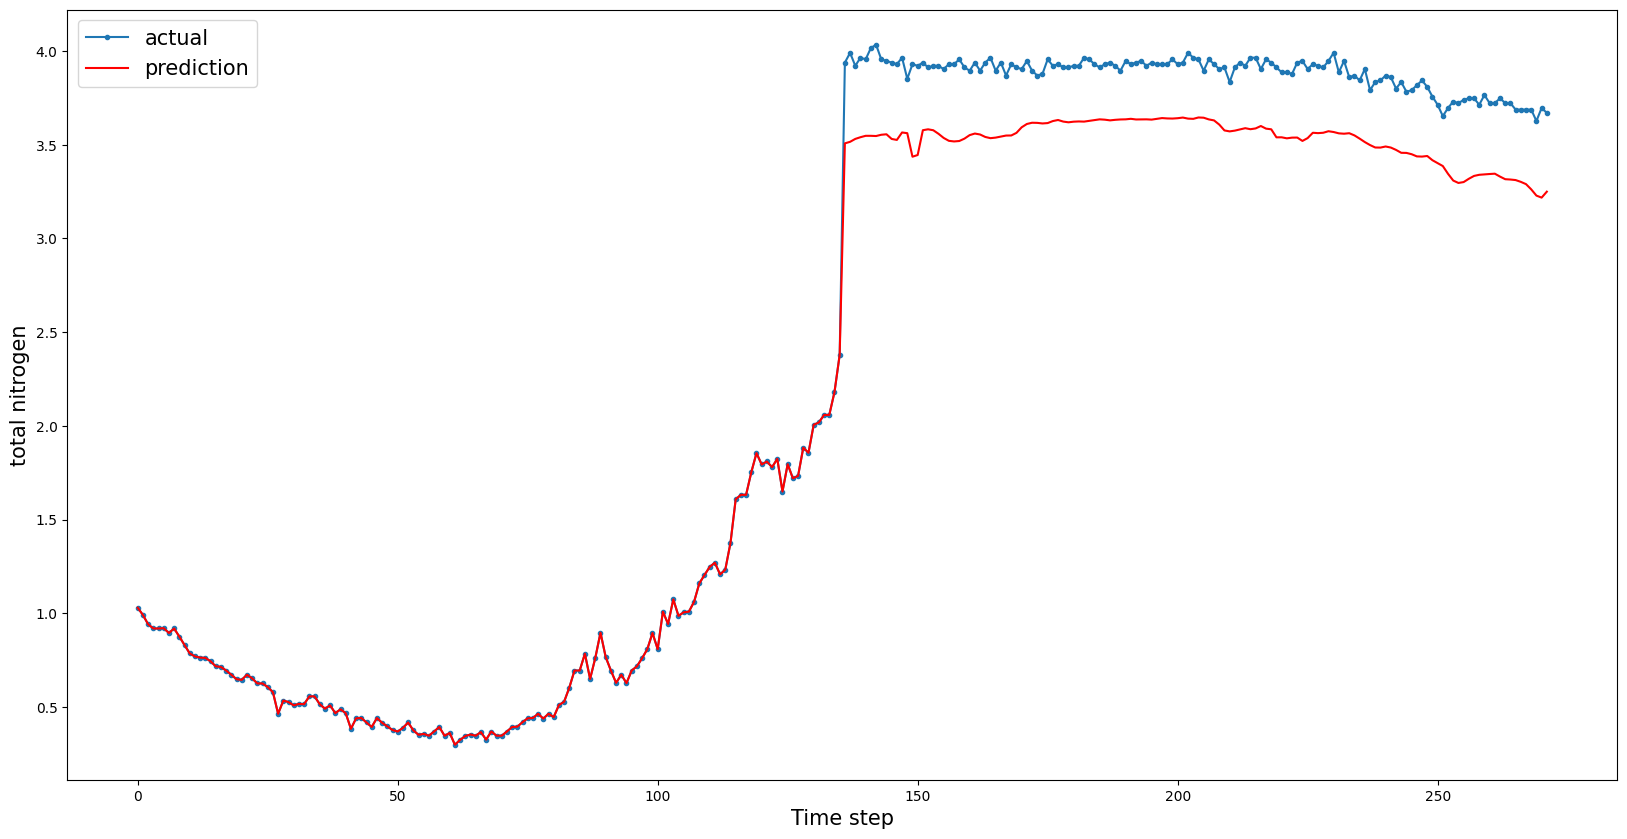

In [32]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **GRU**

In [34]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(32, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True),
    tf.keras.layers.GRU(32),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_gru_less_training_samples.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.44059, saving model to model_gru_less_training_samples.h5
35/35 - 6s - loss: 0.1722 - val_loss: 0.4406 - lr: 0.0010 - 6s/epoch - 170ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.44059 to 0.40592, saving model to model_gru_less_training_samples.h5
35/35 - 0s - loss: 0.0819 - val_loss: 0.4059 - lr: 0.0010 - 425ms/epoch - 12ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.40592 to 0.32977, saving model to model_gru_less_training_samples.h5
35/35 - 0s - loss: 0.0751 - val_loss: 0.3298 - lr: 0.0010 - 414ms/epoch - 12ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.32977 to 0.28581, saving model to model_gru_less_training_samples.h5
35/35 - 0s - loss: 0.0638 - val_loss: 0.2858 - lr: 0.0010 - 456ms/epoch - 13ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.28581 to 0.16741, saving model to model_gru_less_training_samples.h5
35/35 - 0s - loss: 0.0647 - val_loss: 0.1674 - lr: 0.0010 - 424ms/epoch - 12ms/step
Epoch 

training progress

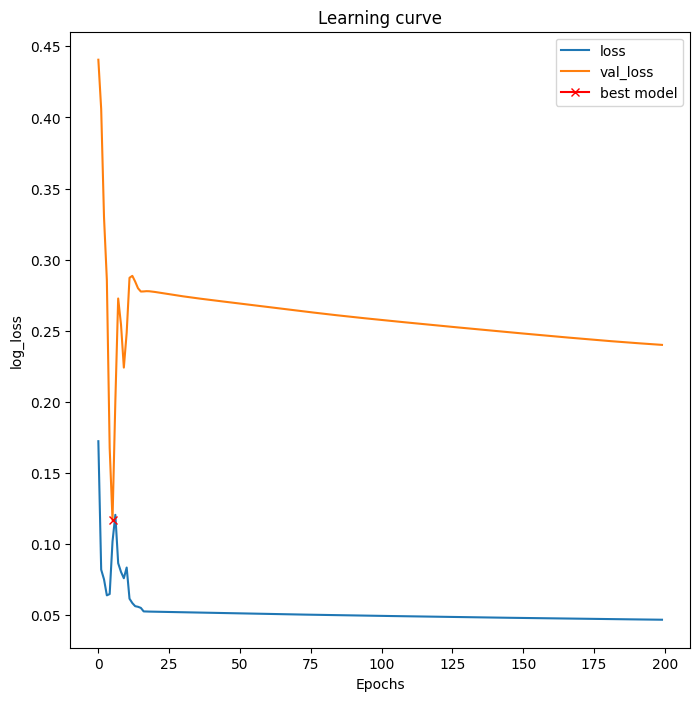

In [35]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

testing the model

In [36]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 1s 9ms/step
Train RMSE: 0.549
Train MAE : 0.135
Train R2  : 0.9378
23/23 [==============================] - 0s 6ms/step
Validation RMSE: 2.032
Validation MAE : 0.901
Validation R2  : 0.2076
22/22 [==============================] - 0s 6ms/step
Test RMSE: 2.849
Test MAE : 1.336
Test R2  : 0.6078


Actual and predicted values

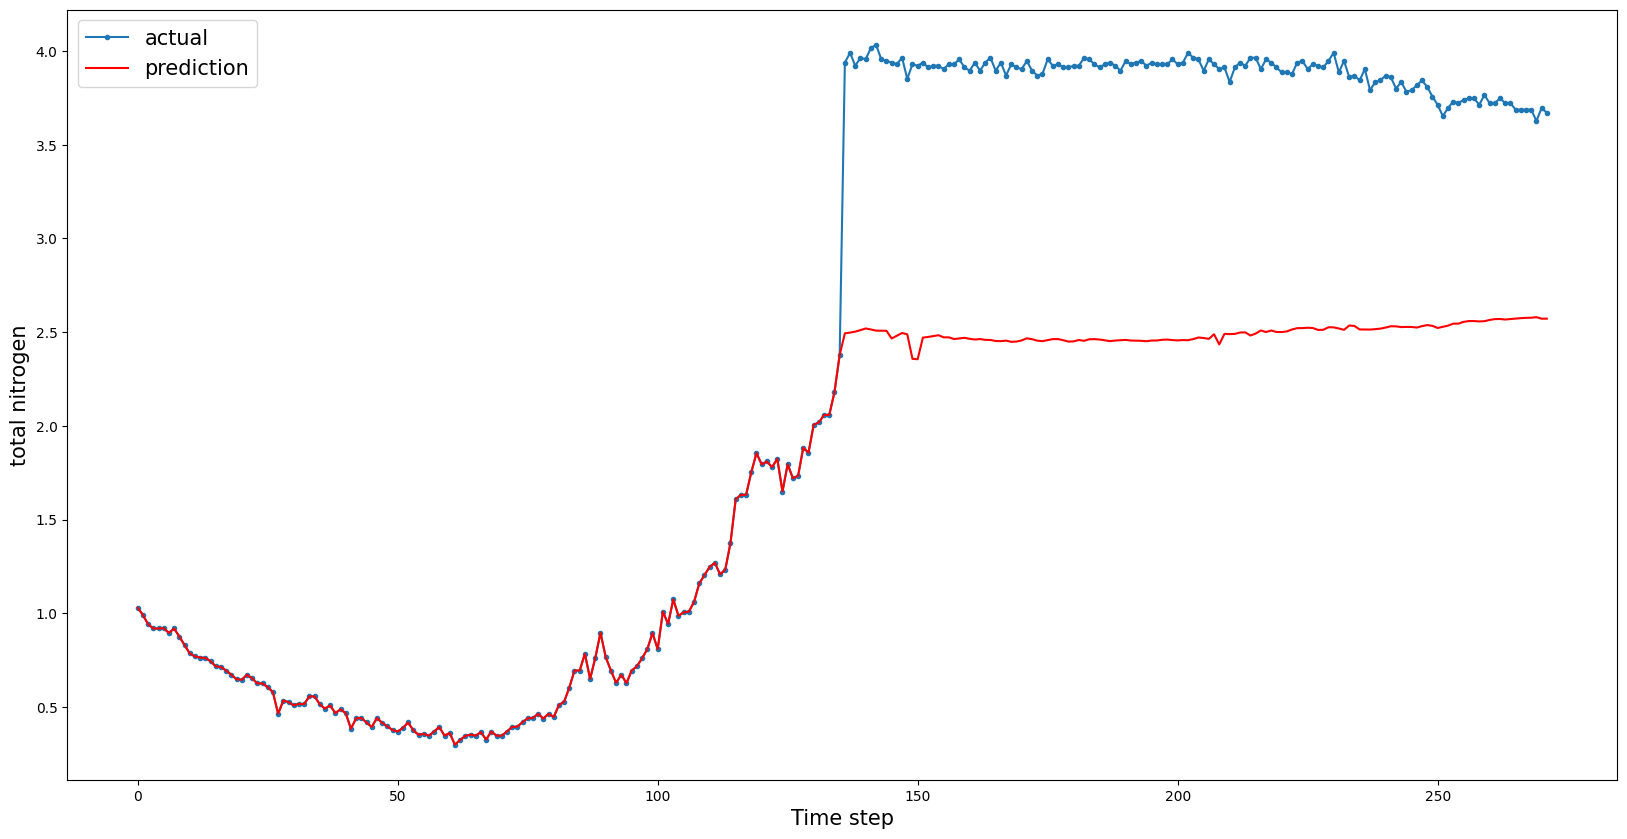

In [38]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

**Loading and testing the saved model**

In [39]:
model = keras.models.load_model('model_gru_less_training_samples.h5',custom_objects={'root_mean_squared_error':                   
root_mean_squared_error})
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 2s 5ms/step
Train RMSE: 1.139
Train MAE : 0.414
Train R2  : 0.7284
23/23 [==============================] - 0s 5ms/step
Validation RMSE: 1.110
Validation MAE : 0.431
Validation R2  : 0.7648
22/22 [==============================] - 0s 4ms/step
Test RMSE: 1.897
Test MAE : 0.892
Test R2  : 0.8250


actual and predicted values

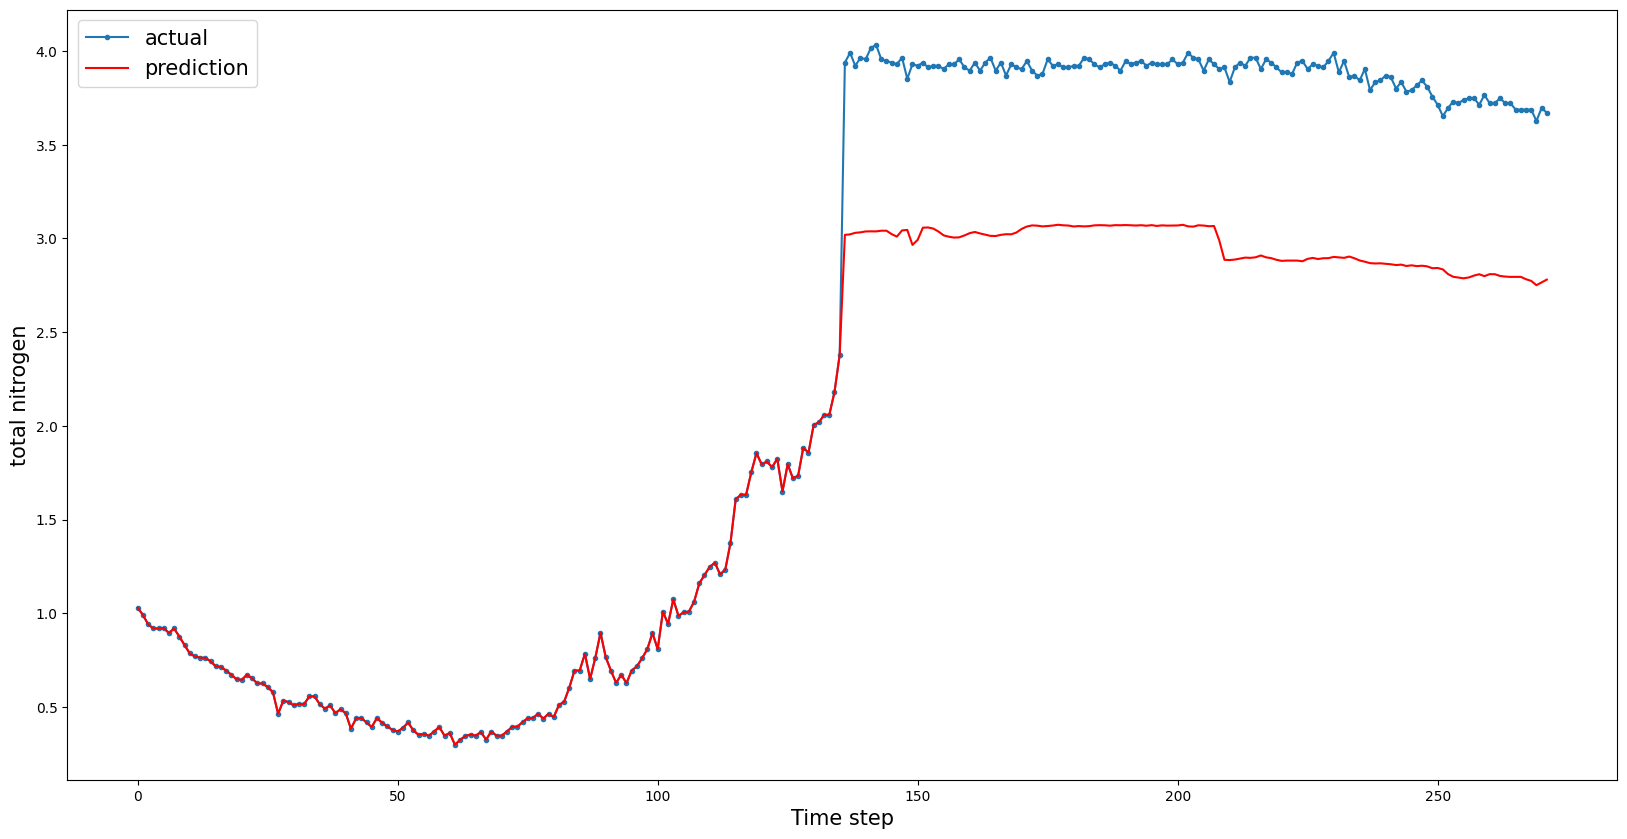

In [41]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **Bidirectional GRU**

In [42]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.GRU(32)),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')


callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_bid_gru_less_training_samples.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.31965, saving model to model_bid_gru_less_training_samples.h5
35/35 - 16s - loss: 0.1207 - val_loss: 0.3196 - lr: 0.0010 - 16s/epoch - 470ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.31965
35/35 - 1s - loss: 0.0720 - val_loss: 0.3765 - lr: 0.0010 - 669ms/epoch - 19ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.31965 to 0.24842, saving model to model_bid_gru_less_training_samples.h5
35/35 - 1s - loss: 0.0712 - val_loss: 0.2484 - lr: 0.0010 - 711ms/epoch - 20ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.24842
35/35 - 1s - loss: 0.0657 - val_loss: 0.2908 - lr: 0.0010 - 531ms/epoch - 15ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.24842 to 0.14391, saving model to model_bid_gru_less_training_samples.h5
35/35 - 1s - loss: 0.0637 - val_loss: 0.1439 - lr: 0.0010 - 556ms/epoch - 16ms/step
Epoch 6/200

Epoch 6: val_loss did not improve from 0.14391
35/35 - 1s - loss: 0.0793 - val_loss: 0.1562

training progress

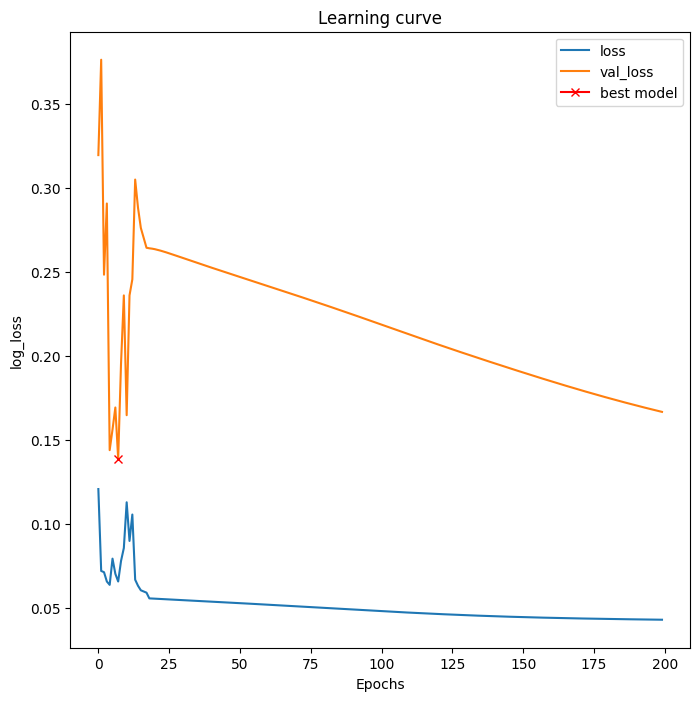

In [43]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

testing the model

In [44]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 2s 5ms/step
Train RMSE: 0.508
Train MAE : 0.128
Train R2  : 0.9498
23/23 [==============================] - 0s 5ms/step
Validation RMSE: 1.423
Validation MAE : 0.625
Validation R2  : 0.6129
22/22 [==============================] - 0s 5ms/step
Test RMSE: 2.100
Test MAE : 0.982
Test R2  : 0.7863


actual and predicted values

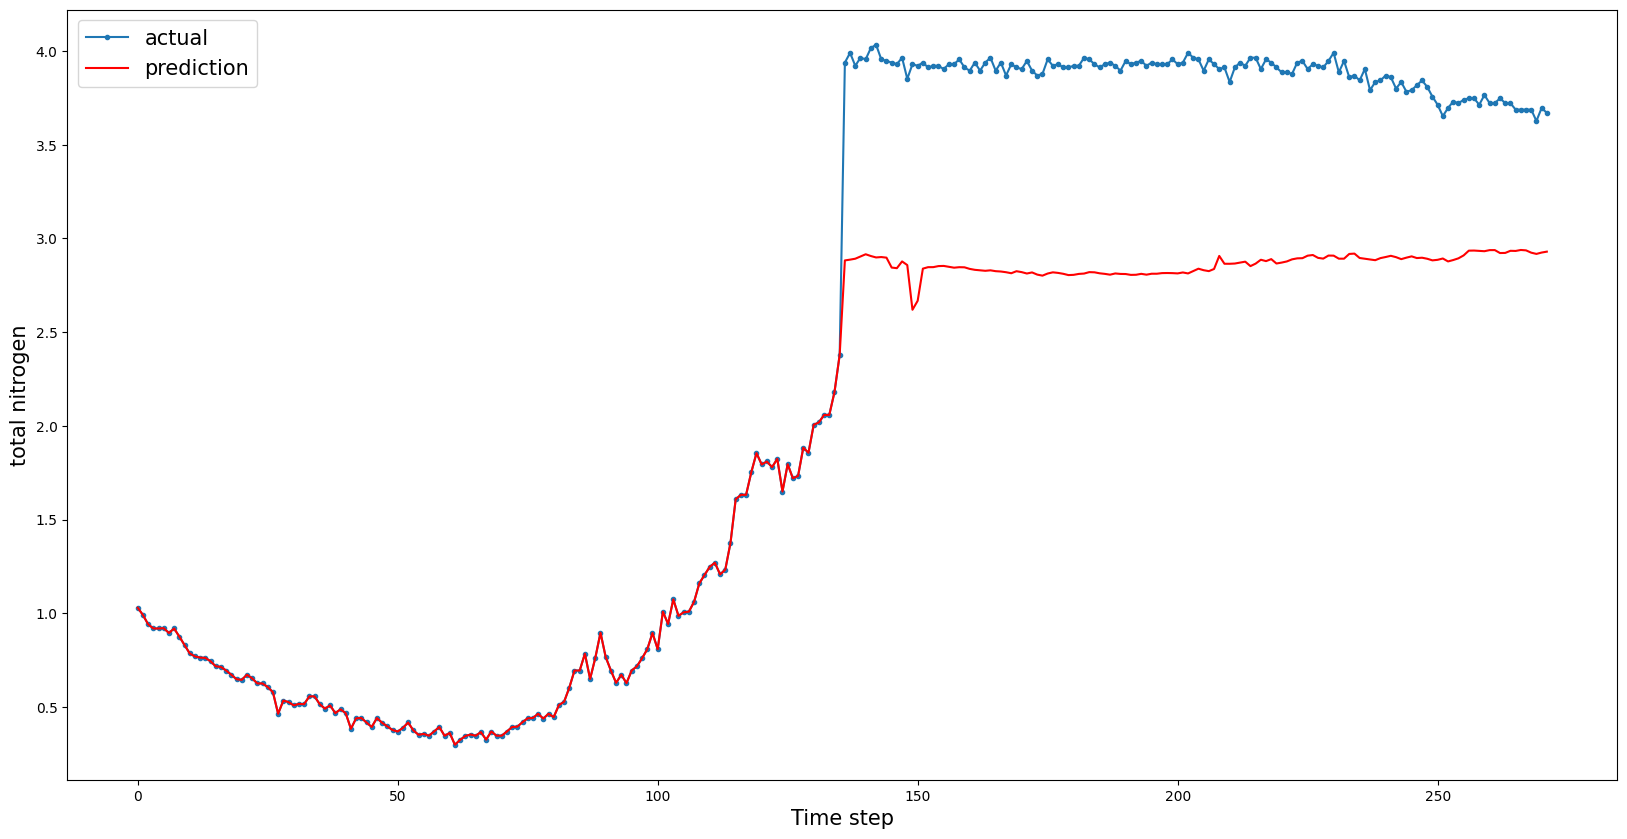

In [46]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

Loading and testing the saved model

In [47]:
model = keras.models.load_model('model_bid_gru_less_training_samples.h5',custom_objects={'root_mean_squared_error':                   
root_mean_squared_error})
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 2s 5ms/step
Train RMSE: 0.967
Train MAE : 0.335
Train R2  : 0.8042
23/23 [==============================] - 0s 5ms/step
Validation RMSE: 1.142
Validation MAE : 0.516
Validation R2  : 0.7483
22/22 [==============================] - 0s 5ms/step
Test RMSE: 1.249
Test MAE : 0.583
Test R2  : 0.9232


Actual and predicted values

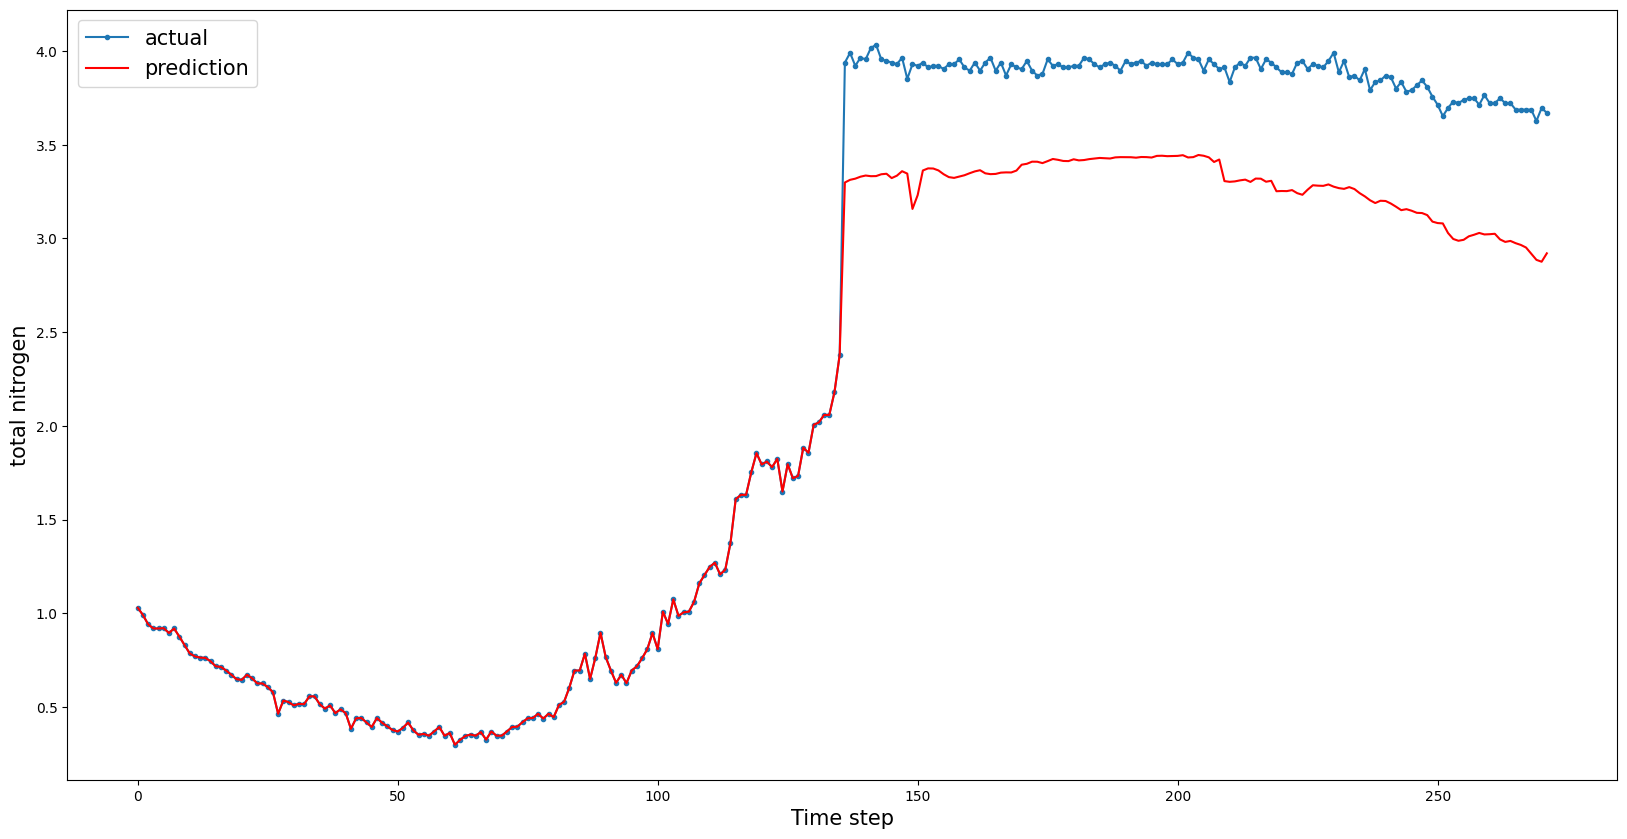

In [49]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

### **Deeper architecture**

##### **LSTM**

In [93]:
model = Sequential()
model.add(LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
model.add(Dropout(0.4))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(256,return_sequences=True))
model.add(LSTM(128,return_sequences=True))
model.add(LSTM(64))
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(32,activation='relu'))
model.add(Dense(8))
model.add(Dense(1))


model.compile(loss=root_mean_squared_error, optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_lstm_deeper_less_training_samples.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.49133, saving model to model_lstm_deeper_less_training_samples.h5
35/35 - 27s - loss: 0.1801 - val_loss: 0.4913 - lr: 0.0010 - 27s/epoch - 786ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.49133 to 0.36713, saving model to model_lstm_deeper_less_training_samples.h5
35/35 - 1s - loss: 0.1451 - val_loss: 0.3671 - lr: 0.0010 - 1s/epoch - 29ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.36713
35/35 - 1s - loss: 0.1062 - val_loss: 0.3765 - lr: 0.0010 - 852ms/epoch - 24ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.36713 to 0.36524, saving model to model_lstm_deeper_less_training_samples.h5
35/35 - 1s - loss: 0.1095 - val_loss: 0.3652 - lr: 0.0010 - 1s/epoch - 30ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.36524 to 0.36038, saving model to model_lstm_deeper_less_training_samples.h5
35/35 - 1s - loss: 0.1045 - val_loss: 0.3604 - lr: 0.0010 - 1s/epoch - 31ms/step
Epoch 6/200

Epoch 6: val_loss improv

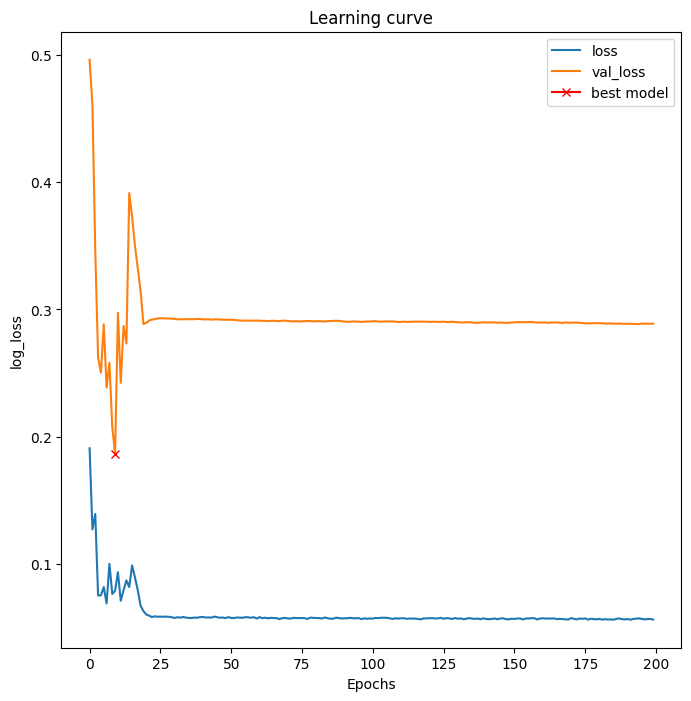

In [70]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [71]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 3s 15ms/step
Train RMSE: 0.624
Train MAE : 0.159
Train R2  : 0.9180
23/23 [==============================] - 0s 10ms/step
Validation RMSE: 2.528
Validation MAE : 1.086
Validation R2  : -0.2231
22/22 [==============================] - 0s 10ms/step
Test RMSE: 3.689
Test MAE : 1.735
Test R2  : 0.3426


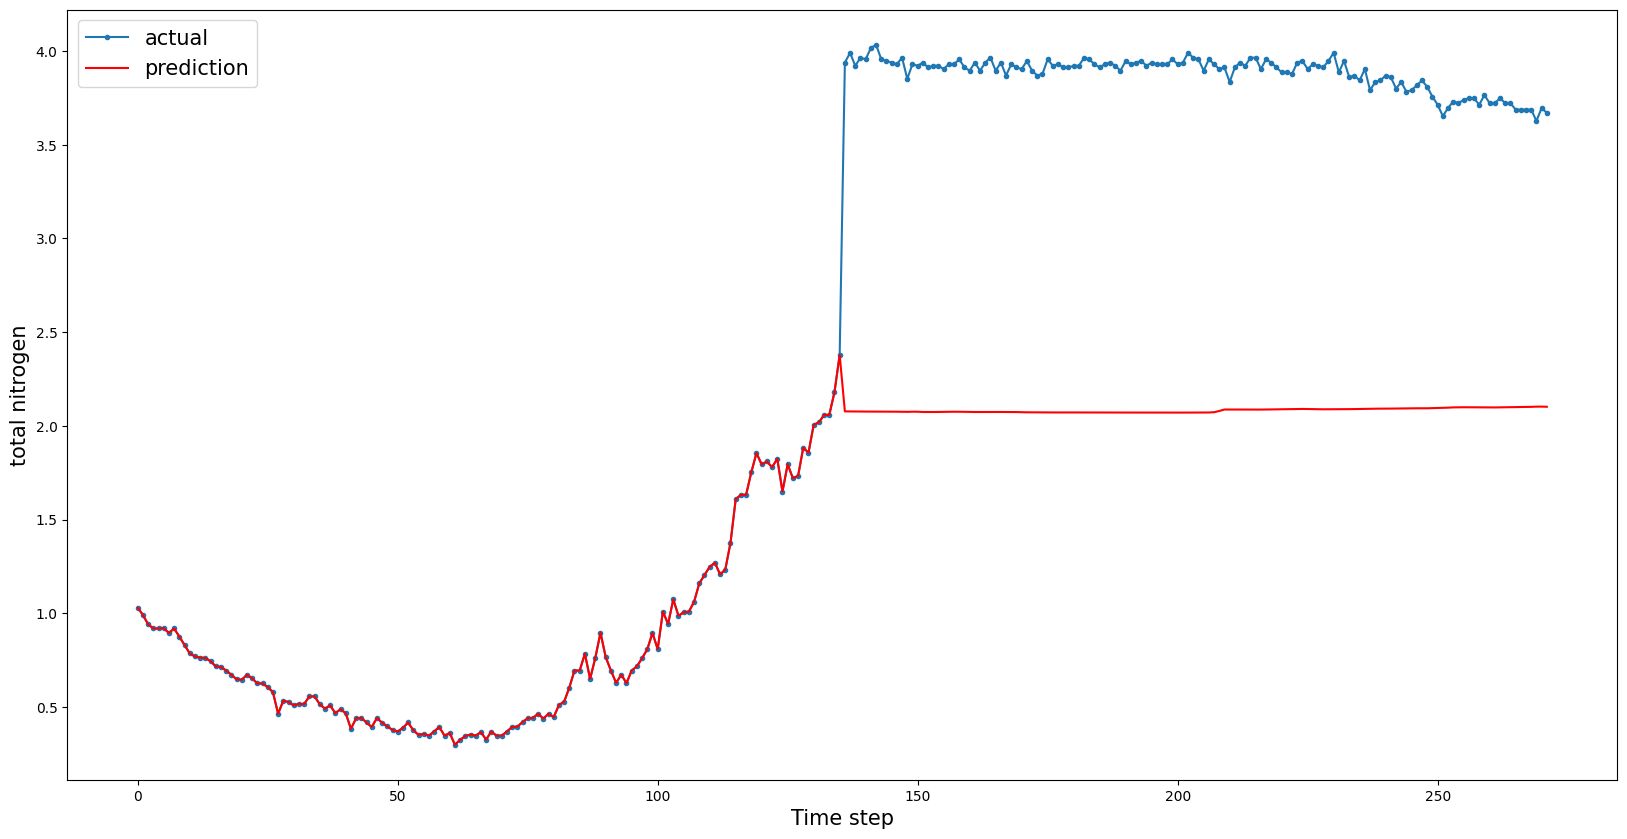

In [73]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

testing saved model 

In [74]:
model = keras.models.load_model('model_lstm_deep_less_training_samples.h5',custom_objects={'root_mean_squared_error':                   
root_mean_squared_error})
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 3s 13ms/step
Train RMSE: 1.086
Train MAE : 0.401
Train R2  : 0.7512
23/23 [==============================] - 0s 7ms/step
Validation RMSE: 1.769
Validation MAE : 0.699
Validation R2  : 0.4024
22/22 [==============================] - 0s 7ms/step
Test RMSE: 2.792
Test MAE : 1.312
Test R2  : 0.6228


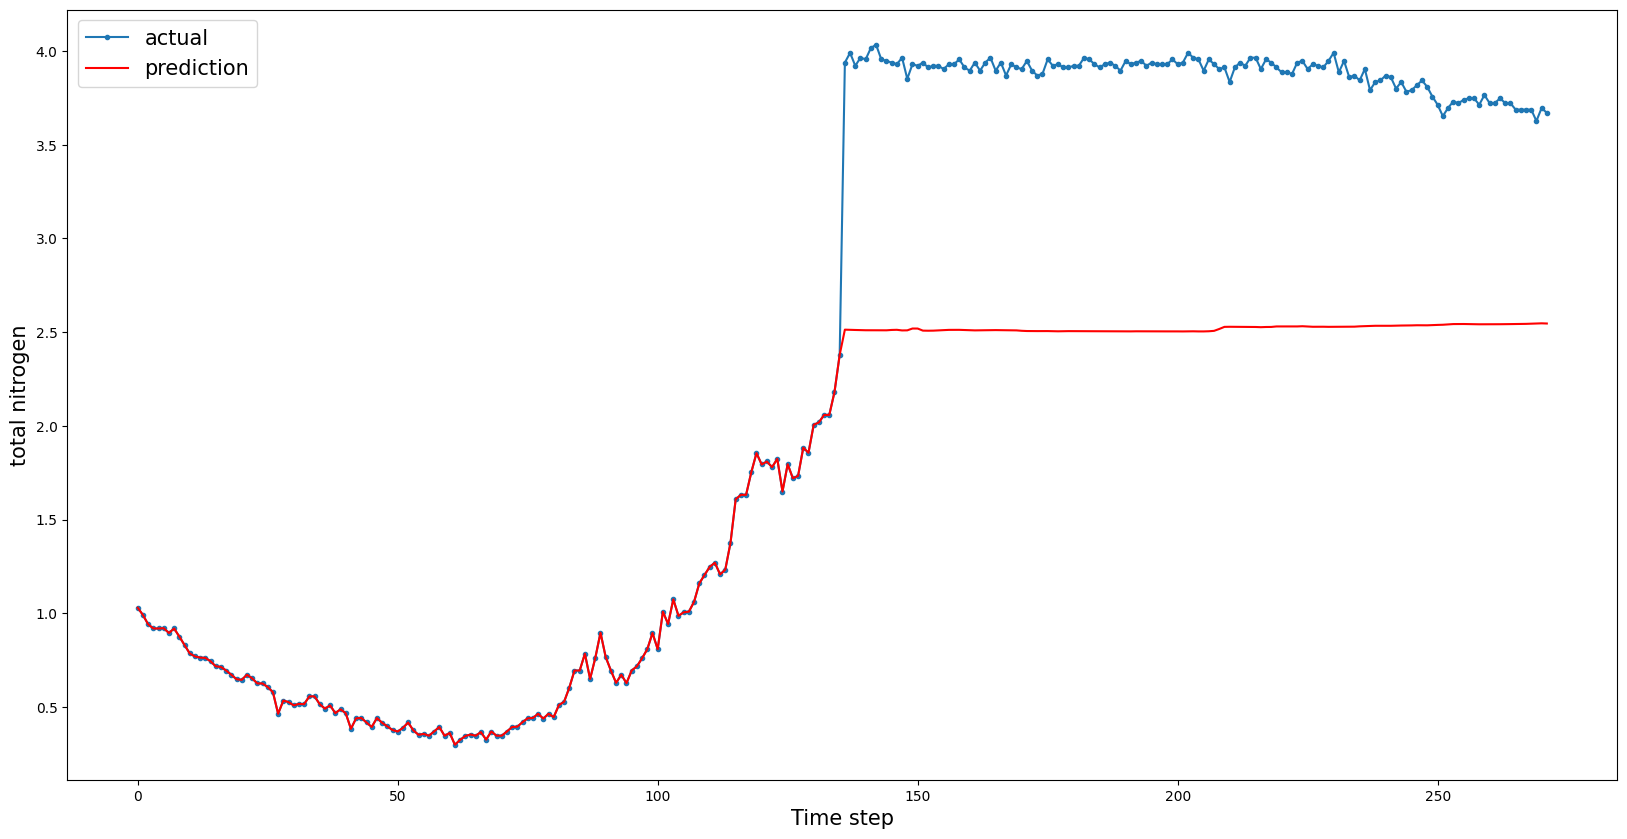

In [75]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **Bidirectional LSTM**

In [77]:
model = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    Dropout(0.2),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(8),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')


callbacks = [
    # keras.callbacks.EarlyStopping(patience=5, verbose=1),
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_lstm_deep_bid_less_training_samples.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)


Epoch 1/200

Epoch 1: val_loss improved from inf to 0.45405, saving model to model_lstm_deep_bid_less_training_samples.h5
35/35 - 31s - loss: 0.1414 - val_loss: 0.4541 - lr: 0.0010 - 31s/epoch - 899ms/step
Epoch 2/200

Epoch 2: val_loss improved from 0.45405 to 0.44860, saving model to model_lstm_deep_bid_less_training_samples.h5
35/35 - 1s - loss: 0.1135 - val_loss: 0.4486 - lr: 0.0010 - 1s/epoch - 41ms/step
Epoch 3/200

Epoch 3: val_loss improved from 0.44860 to 0.39860, saving model to model_lstm_deep_bid_less_training_samples.h5
35/35 - 1s - loss: 0.1097 - val_loss: 0.3986 - lr: 0.0010 - 1s/epoch - 38ms/step
Epoch 4/200

Epoch 4: val_loss improved from 0.39860 to 0.24960, saving model to model_lstm_deep_bid_less_training_samples.h5
35/35 - 1s - loss: 0.0828 - val_loss: 0.2496 - lr: 0.0010 - 1s/epoch - 31ms/step
Epoch 5/200

Epoch 5: val_loss did not improve from 0.24960
35/35 - 1s - loss: 0.0729 - val_loss: 0.2663 - lr: 0.0010 - 923ms/epoch - 26ms/step
Epoch 6/200

Epoch 6: val_los

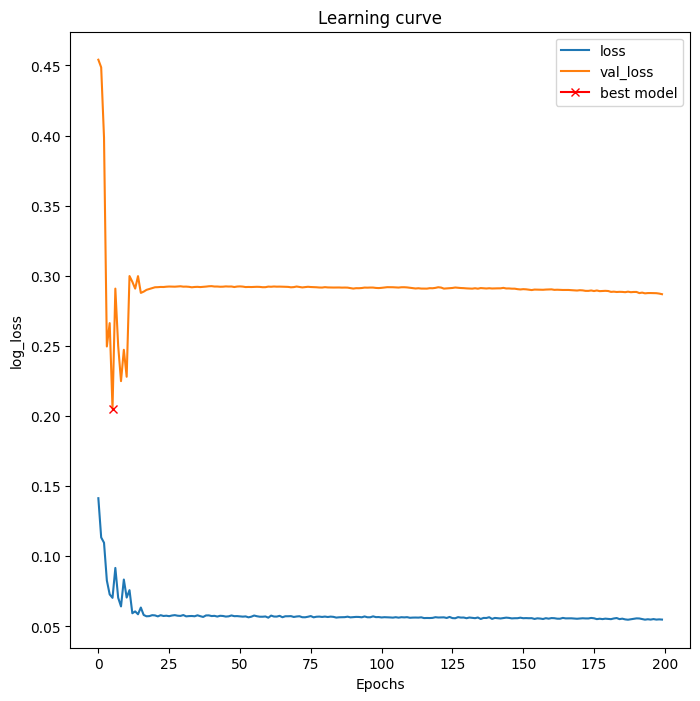

In [78]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [79]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 5s 13ms/step
Train RMSE: 0.621
Train MAE : 0.156
Train R2  : 0.9189
23/23 [==============================] - 0s 10ms/step
Validation RMSE: 2.520
Validation MAE : 1.079
Validation R2  : -0.2146
22/22 [==============================] - 0s 9ms/step
Test RMSE: 3.687
Test MAE : 1.733
Test R2  : 0.3435


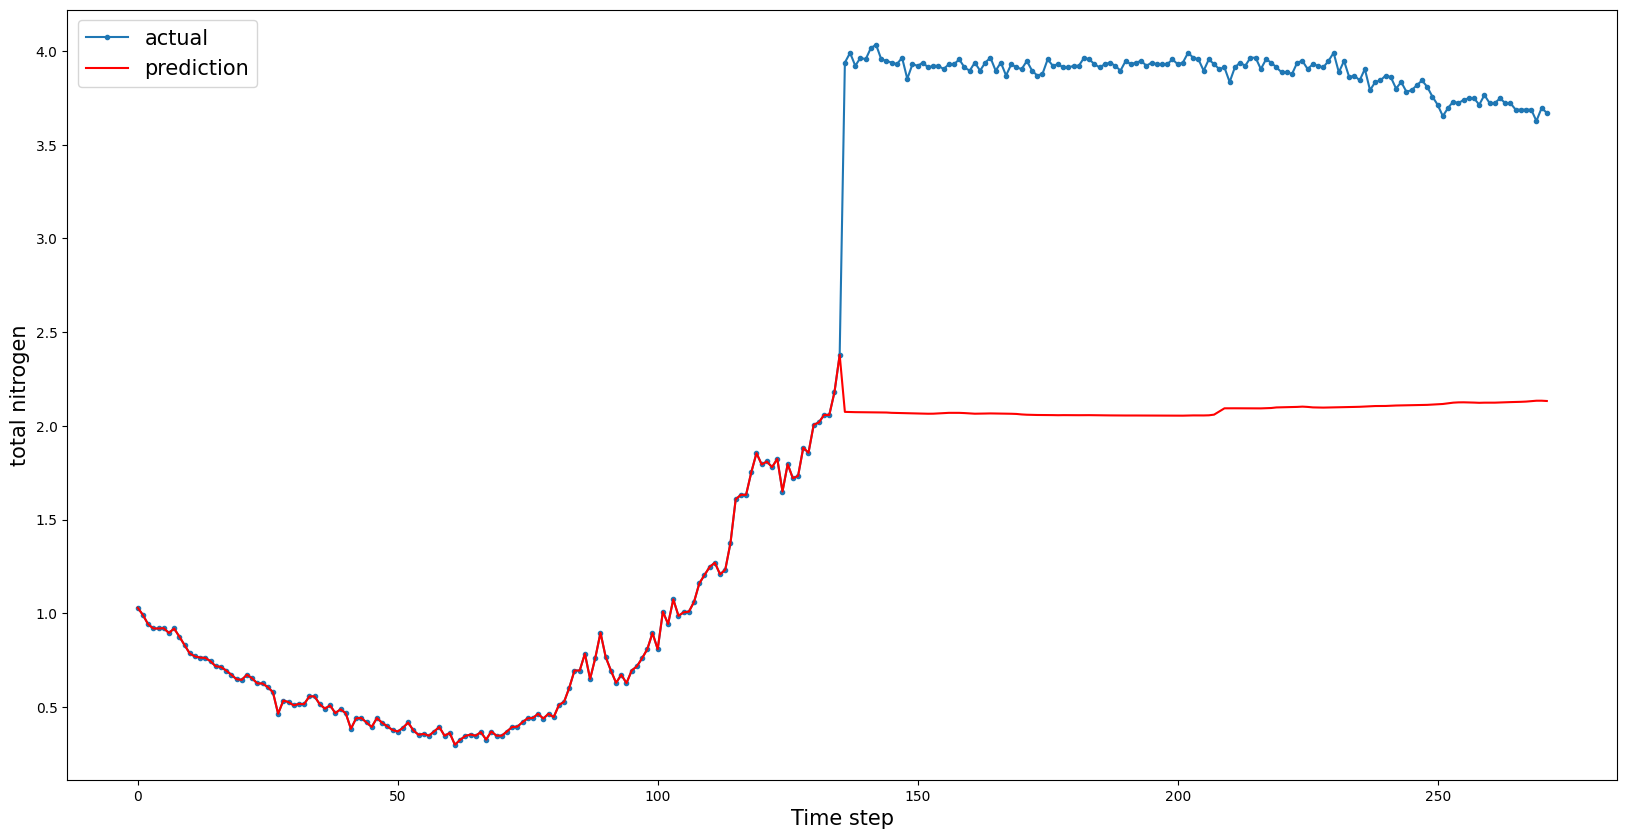

In [81]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

Saved model

In [82]:
model = keras.models.load_model('model_lstm_deep_bid_less_training_samples.h5',custom_objects={'root_mean_squared_error':                   
root_mean_squared_error})
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 4s 16ms/step
Train RMSE: 0.923
Train MAE : 0.325
Train R2  : 0.8202
23/23 [==============================] - 0s 11ms/step
Validation RMSE: 1.842
Validation MAE : 0.769
Validation R2  : 0.3503
22/22 [==============================] - 0s 11ms/step
Test RMSE: 2.794
Test MAE : 1.314
Test R2  : 0.6222


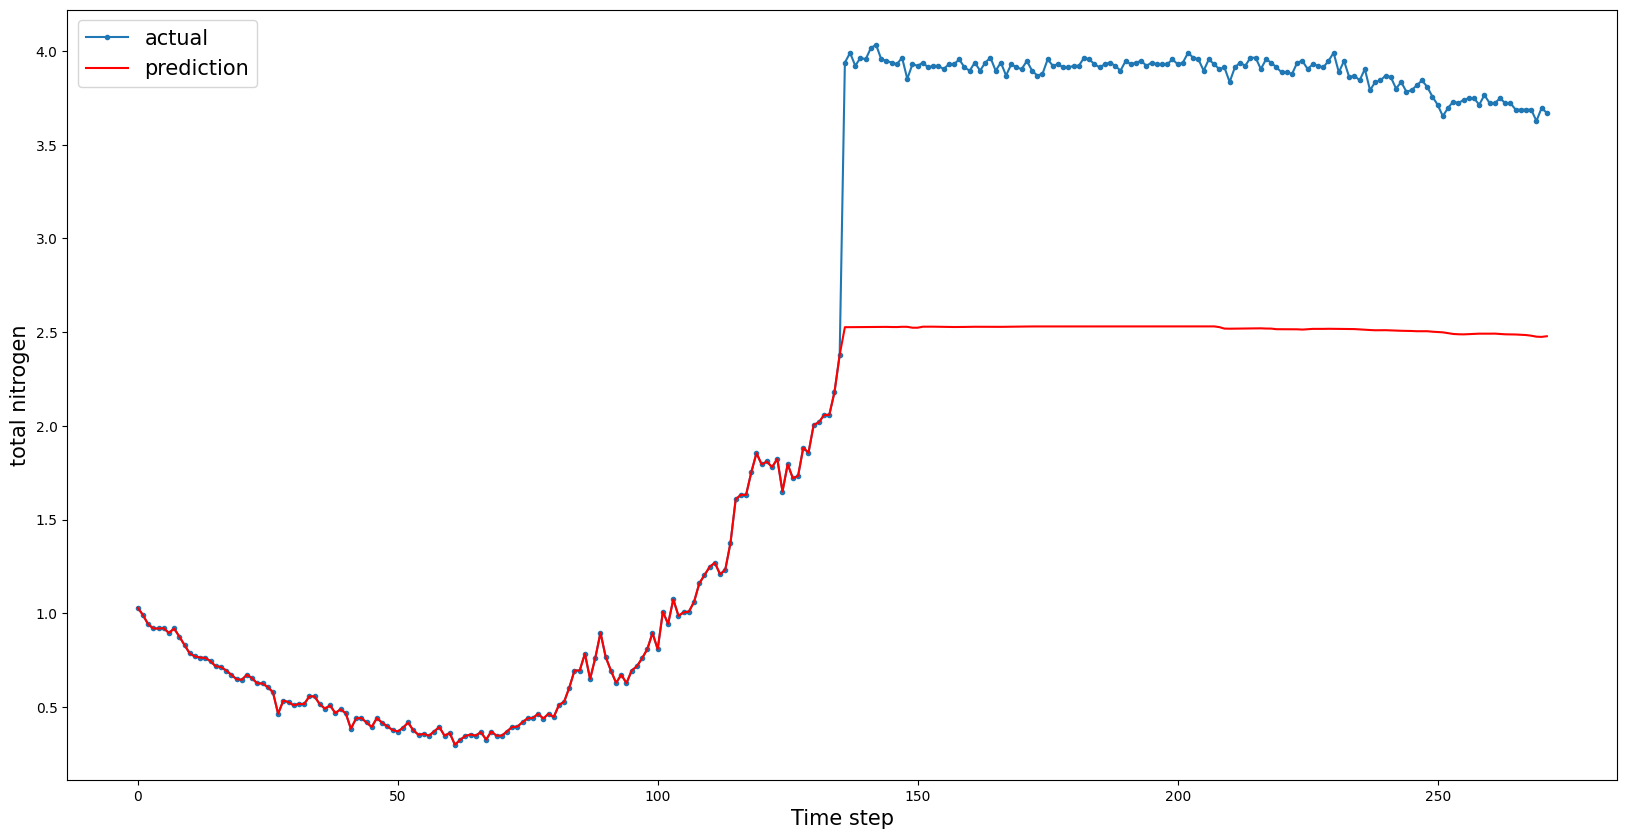

In [84]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

##### **GRU**

In [85]:
model = tf.keras.Sequential([
    tf.keras.layers.GRU(1024, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True),
    tf.keras.layers.GRU(512,return_sequences=True),
    tf.keras.layers.GRU(128,return_sequences=True),
    tf.keras.layers.GRU(64),
    tf.keras.layers.Dense(6, activation='relu'),
    tf.keras.layers.Dense(1)
])
model.compile(loss=root_mean_squared_error,optimizer='adam')

callbacks = [
    keras.callbacks.ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1),
    keras.callbacks.ModelCheckpoint('model_gru_deep_less_training_samples.h5', verbose=1, save_best_only=True)
]

# fit network
history = model.fit(train_X, train_y, epochs=200, batch_size=32, validation_data=(val_X,val_y), verbose=2, shuffle=False,callbacks=callbacks)

Epoch 1/200

Epoch 1: val_loss improved from inf to 0.43623, saving model to model_gru_deep_less_training_samples.h5
35/35 - 12s - loss: 0.1437 - val_loss: 0.4362 - lr: 0.0010 - 12s/epoch - 357ms/step
Epoch 2/200

Epoch 2: val_loss did not improve from 0.43623
35/35 - 1s - loss: 0.0877 - val_loss: 0.4453 - lr: 0.0010 - 675ms/epoch - 19ms/step
Epoch 3/200

Epoch 3: val_loss did not improve from 0.43623
35/35 - 1s - loss: 0.1069 - val_loss: 0.4728 - lr: 0.0010 - 544ms/epoch - 16ms/step
Epoch 4/200

Epoch 4: val_loss did not improve from 0.43623
35/35 - 1s - loss: 0.1307 - val_loss: 0.4673 - lr: 0.0010 - 508ms/epoch - 15ms/step
Epoch 5/200

Epoch 5: val_loss improved from 0.43623 to 0.38745, saving model to model_gru_deep_less_training_samples.h5
35/35 - 1s - loss: 0.1000 - val_loss: 0.3874 - lr: 0.0010 - 717ms/epoch - 20ms/step
Epoch 6/200

Epoch 6: val_loss improved from 0.38745 to 0.30185, saving model to model_gru_deep_less_training_samples.h5
35/35 - 1s - loss: 0.0835 - val_loss: 0.3

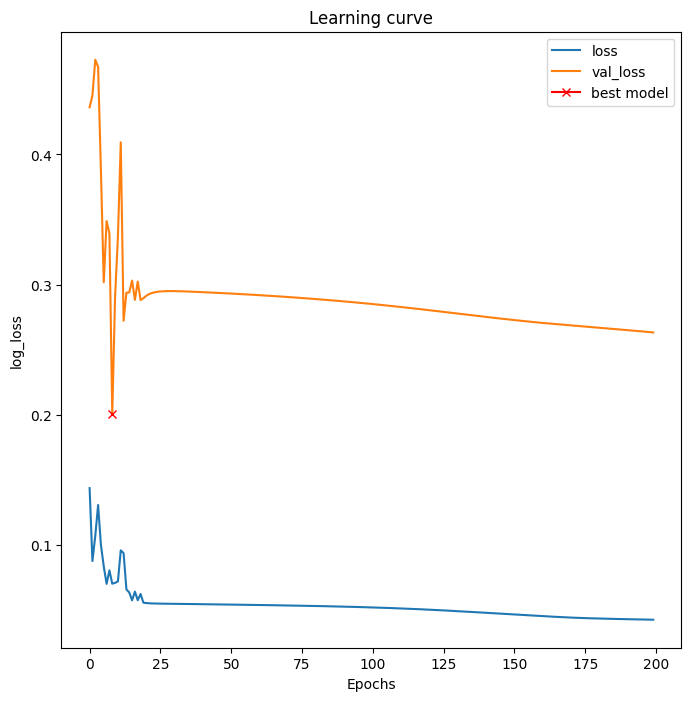

In [86]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(history.history["loss"], label="loss")
plt.plot(history.history["val_loss"], label="val_loss")
plt.plot( np.argmin(history.history["val_loss"]), np.min(history.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

In [87]:
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 2s 13ms/step
Train RMSE: 0.505
Train MAE : 0.131
Train R2  : 0.9535
23/23 [==============================] - 0s 5ms/step
Validation RMSE: 2.357
Validation MAE : 0.991
Validation R2  : -0.0622
22/22 [==============================] - 0s 5ms/step
Test RMSE: 3.429
Test MAE : 1.609
Test R2  : 0.4321


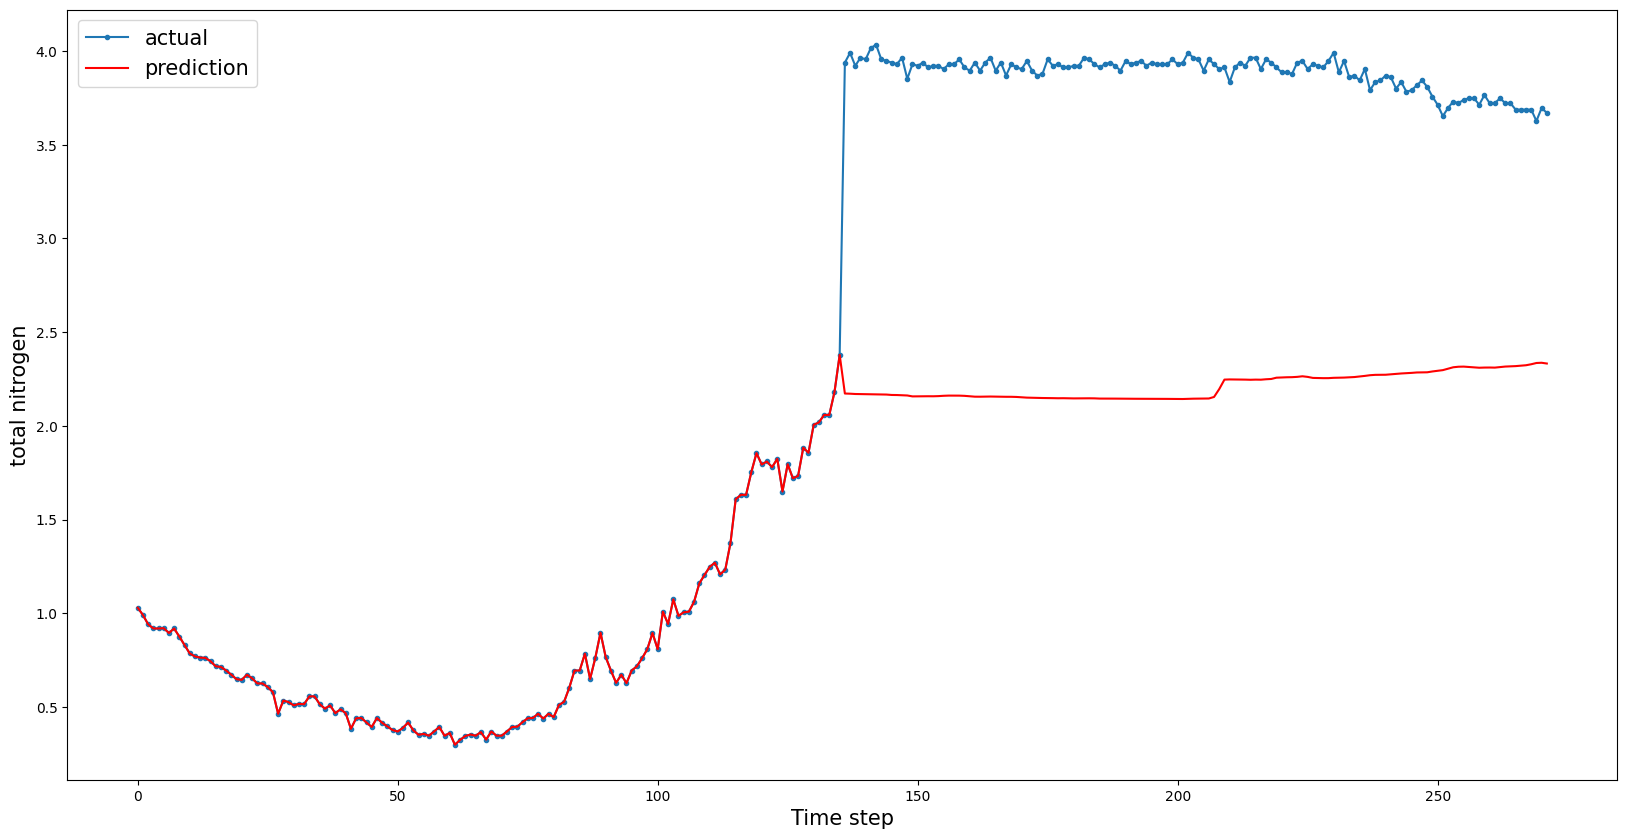

In [89]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()

Saved model

In [90]:
model = keras.models.load_model('model_gru_deep_less_training_samples.h5',custom_objects={'root_mean_squared_error':                   
root_mean_squared_error})
# make a prediction
y_pred = model.predict(train_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([train_X[:,:,0],y_pred]).reshape(-1,5))
inv_train_y = scaler.inverse_transform(np.array([train_X[:,:,0],train_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_train_y))
r2score = r2_score(inv_train_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_train_y)
print('Train RMSE: %.3f' % rmse)
print('Train MAE : %.3f' % mae)
print('Train R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(val_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([val_X[:,:,0],y_pred]).reshape(-1,5))
inv_val_y = scaler.inverse_transform(np.array([val_X[:,:,0],val_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_val_y))
r2score = r2_score(inv_val_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_val_y)
print('Validation RMSE: %.3f' % rmse)
print('Validation MAE : %.3f' % mae)
print('Validation R2  : %.4f' % r2score)

# make a prediction
y_pred = model.predict(test_X)
# invert scaling for forecast
inv_y_pred = scaler.inverse_transform(np.array([test_X[:,:,0],y_pred]).reshape(-1,5))
inv_test_y = scaler.inverse_transform(np.array([test_X[:,:,0],test_y.reshape(-1,1)]).reshape(-1,5))
# calculate RMSE
rmse = np.sqrt(mean_squared_error(inv_y_pred, inv_test_y))
r2score = r2_score(inv_test_y, inv_y_pred)
mae = mean_absolute_error(inv_y_pred, inv_test_y)
print('Test RMSE: %.3f' % rmse)
print('Test MAE : %.3f' % mae)
print('Test R2  : %.4f' % r2score)


35/35 [==============================] - 2s 10ms/step
Train RMSE: 0.880
Train MAE : 0.362
Train R2  : 0.8443
23/23 [==============================] - 0s 6ms/step
Validation RMSE: 1.842
Validation MAE : 0.746
Validation R2  : 0.3501
22/22 [==============================] - 0s 6ms/step
Test RMSE: 2.946
Test MAE : 1.385
Test R2  : 0.5796


In [91]:
inv_y_pred = inv_y_pred[:,1]
inv_test_y = inv_test_y[:,1]

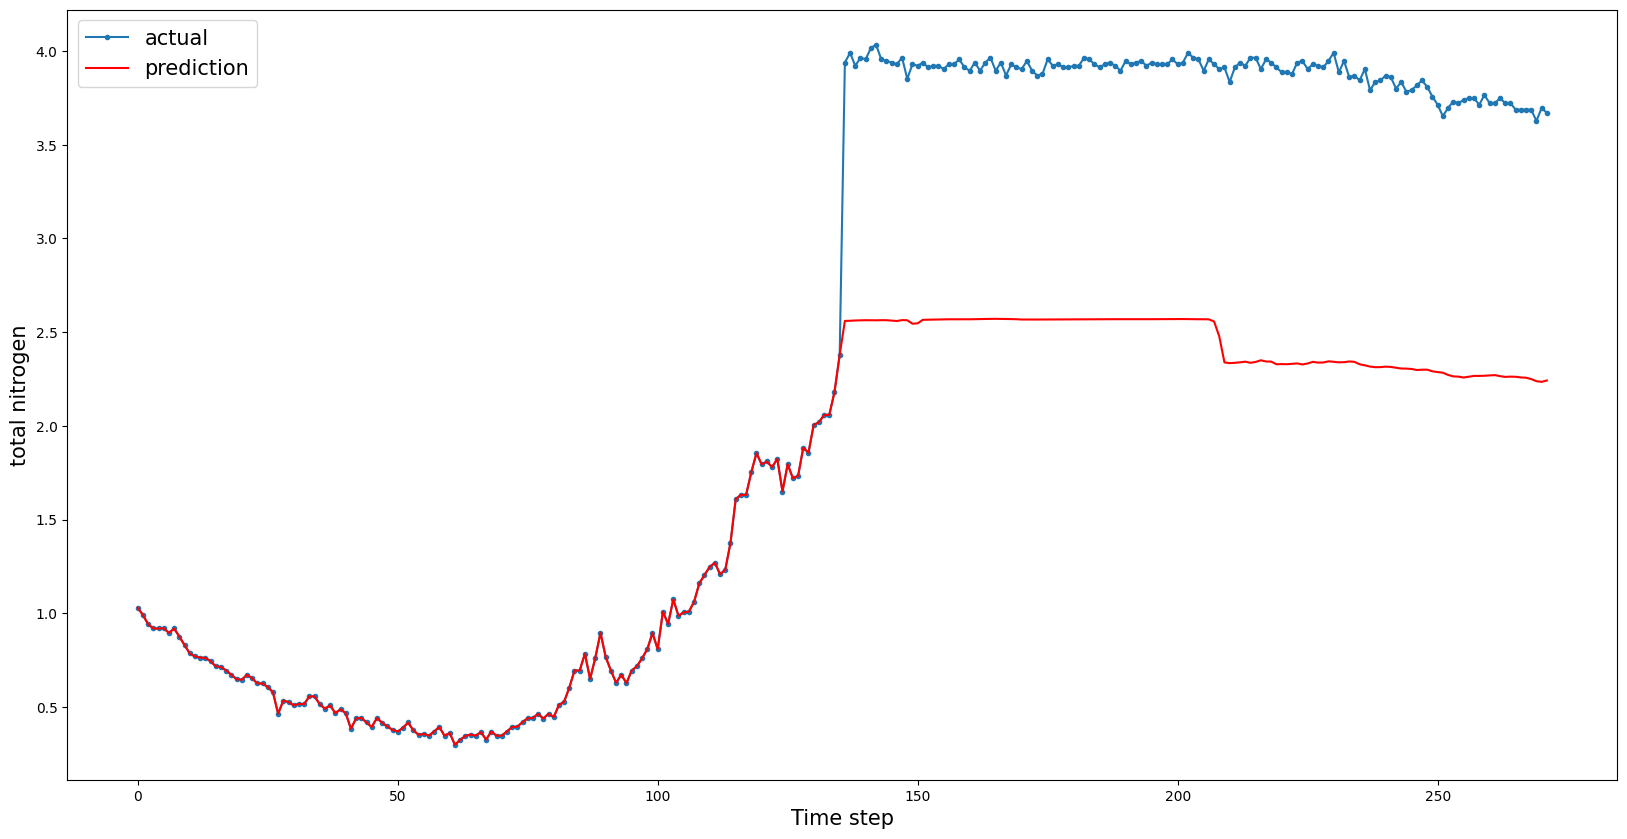

In [92]:
aa=[x for x in range(len(inv_test_y))]
plt.plot(aa, inv_test_y, marker='.', label="actual")
plt.plot(aa, inv_y_pred, 'r', label="prediction")
plt.ylabel('total nitrogen', size=15)
plt.xlabel('Time step', size=15)
plt.legend(fontsize=15)
plt.show()